In [1]:
import numpy as np
import pandas as pd
import json
import re
import os
import sys
import ast
import matplotlib.pyplot as plt
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Species
from disorder.composition import merged_comp
from disorder.composition import composition_from_formula

np.set_printoptions(legacy='1.21')

# Data loading and filtering

In [2]:
# path='path to the collection of CIFs'
path='CIFs/cifs/'
list_of_files=os.listdir(path)
len(list_of_files)

221688

In [3]:
structure=pd.read_csv('data/noH_clean-info.csv')
with open('disorder_results_noH_clean.json', 'r') as fp:
    data = json.load(fp)  
#with open('calculated_data/disorder_results_with_H.json', 'r') as fp:
#    data1 = json.load(fp)

In [4]:
print('we use only data of compounds which do not contain hydrogen')
print('The number of compounds with no H with disorder labels: ', len(data))

we use only data of compounds which do not contain hydrogen
The number of compounds with no H with disorder labels:  176792


In [5]:
print('we filter only entries at room temperature and normal pressure')
disorder=pd.DataFrame.from_dict(data,orient='index')
disorder=disorder.merge(structure,how='inner',left_on='ICSD_ID',right_on='Col_code')
disorder=disorder.loc[disorder['Temperature']<310]
disorder=disorder.loc[disorder['Temperature']>270]
disorder=disorder.loc[disorder['Pressure']<0.11]
disorder.reset_index(drop=True,inplace=True)

# Initialize an empty list to store ICSD_IDs with missing entropy data
missing_ids = []
# Initialize a DataFrame to store filtered-out entries
missing_entries = pd.DataFrame()

# Check if 'orbit_disorder' exists in the DataFrame
if 'orbit_disorder' in disorder.columns:
    # Identify missing entries (NaN or empty strings) BEFORE filtering
    missing_mask = disorder['orbit_disorder'].isna() | (disorder['orbit_disorder'] == '')
    missing_ids = disorder.index[missing_mask].tolist()
    
    # Save the filtered-out entries for inspection
    missing_entries = disorder[missing_mask]
    
    # Filter out rows with missing entropy data (both NaN and empty strings)
    disorder = disorder[~missing_mask]
    
    # Reset index after filtering
    disorder.reset_index(drop=True, inplace=True)
else:
    print("'orbit_disorder' column not found in the DataFrame.")

# Output results
print('Number of compounds at normal pressure and room temperature: ', len(disorder))
print('Fraction from all compounds: ', len(disorder)/len(list_of_files))
print(f"Filtered DataFrame shape: {disorder.shape}")

we filter only entries at room temperature and normal pressure
Number of compounds at normal pressure and room temperature:  140903
Fraction from all compounds:  0.6355914618743459
Filtered DataFrame shape: (140903, 34)


Adding some useful coloumns, removing compounds with 'COM' orbits:

In [6]:
disorder_sets=[]
for i in range(len(disorder)):
    disorder_sets.append(set(disorder.iloc[i]['orbit_disorder'].values()))
disorder['disorder_set']=disorder_sets
diff_comp=[]
for i in range(len(disorder)):
    comp_el=[]
    for el in Composition(disorder.iloc[i]['formula']).elements:
        comp_el.append(str(el))
    comp_el.sort()
    struct_el=[]
    for spec in disorder.iloc[i]['species'].values():
        for el in spec.keys():
            el=str(Species(el).element)
            struct_el.append(el)
    struct_el=list(set(struct_el))
    struct_el.sort()
    if(comp_el!=struct_el):
        diff_comp.append(i)
disorder.drop(index=diff_comp,inplace=True)
disorder.reset_index(inplace=True,drop=True)
num_el=[]
num_orb=[]
for i in range(len(disorder)):
    num_el.append(len(Composition(disorder.iloc[i]['formula'])))
    num_orb.append(len(disorder.iloc[i]['intersect_orbit_connected']))
disorder['num_el']=num_el
disorder['num_orb']=num_orb
periodic_table=pd.read_csv('data/periodic_table.csv')
elem_list=list(periodic_table['element'].values)

compositions=[]
exc=[]
for i in range(len(disorder)):
    form=disorder.iloc[i]['formula']
    try:
        comp=composition_from_formula(form)
        compositions.append(comp)
    except:
        print('composition error:',i)
        
normalised_compositions=[]
for i,comp in enumerate(compositions):
    try:
        index=len(elem_list)-1
        switch=0
        for el in comp.keys():
            if el not in elem_list:
                switch=1   
        if(switch==0):
            for el in comp.keys():    
                if(elem_list.index(el)<index+1):
                    index=elem_list.index(el)
            devider=float(comp[elem_list[index]])
            for el in comp.keys(): 
                comp[el]=round(float(comp[el])/devider*10000)
            normalised_compositions.append(comp) 
        else:
            print(comp)
            normalised_compositions.append({})
            
    except:
        print(comp)
        normalised_compositions.append({})
        exc.append(i)
merged_compositions=merged_comp(disorder)
disorder['ordered_formula']=merged_compositions
disorder['normalised_composition']=normalised_compositions
disorder=disorder.loc[disorder['normalised_composition']!={}]
disorder.reset_index(drop=True,inplace=True)
com_index=[]
for i in range(len(disorder)):
    orb=disorder.iloc[i]['orbit_disorder'].values()
    if('COM' in orb):
        com_index.append(i)

In [7]:
disorder.iloc[135]['intersect_orbit_connected_occ']

{'0': 1.0, '1': 1.0, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1.0, '6': 1.0}

### 1. All compounds including duplicates

In [8]:
def len_set(a_set):
    set_b=[]
    length=0
    for i in a_set:
        if i not in set_b:
            set_b.append(i)
            length+=1
    return length,set_b

In [9]:
length,list_of_sets=len_set(disorder['disorder_set'].values)
len_dis=[]

for dis_set in list_of_sets:
    len_dis.append(len(disorder.loc[disorder['disorder_set']==dis_set]))

perc=[]
for x in len_dis:
    perc.append(x/np.sum(len_dis))

daa=pd.DataFrame()
daa['disorder_set']=list_of_sets
daa['size']=len_dis
daa['percent']=perc

daa=daa.sort_values(by=['size'],ascending=False).reset_index(drop=True)

In [10]:
len(list_of_sets),len(daa['size'].values[7:])

(170, 163)

In [11]:
db=daa.iloc[7:]
np.mean(db['size'].values),len(db.loc[db['size']>64])

(67.8159509202454, 29)

In [12]:
np.sum(daa['percent'][:5])

0.901485419047146

In [13]:
daa.head(7)

disorder_set   size   percent
0          {O}  71892  0.510223
1       {O, S}  38551  0.273600
2       {O, V}   8380  0.059474
3    {V, O, S}   5281  0.037480
4          {S}   2918  0.020709
5       {O, P}   1566  0.011114
6       {V, S}   1261  0.008949

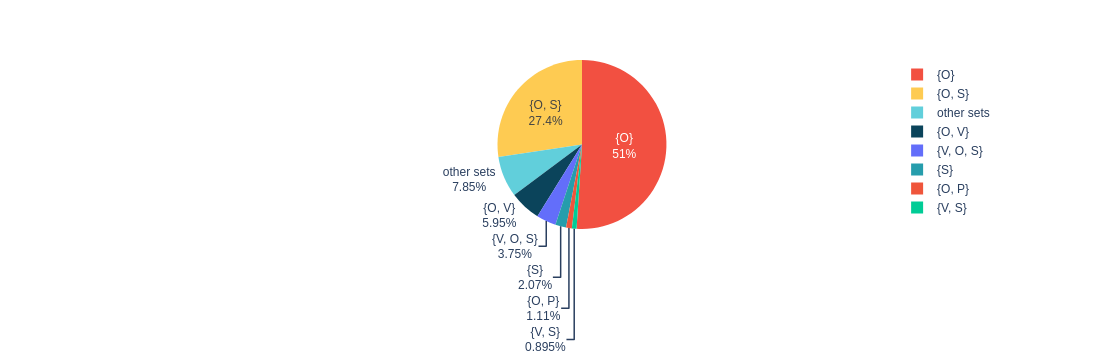

In [14]:
import plotly.express as px
from plotly.colors import label_rgb

names=[]
for name in daa['disorder_set'].values:
    name_str=str(name).replace("'",'')
    names.append(name_str)
daa['name']=names

daa.loc[daa['percent'] < 0.008, 'name'] = 'other sets' # Represent only large countries
fig = px.pie(daa, values='percent', names='name', color='name',
             color_discrete_map={"{O}": label_rgb((242, 80, 65)),
                                 "{S, O}": label_rgb((51, 133, 167)),
                                 "{O, V}": label_rgb((11, 68, 91)),
                                 "{S, O, V}": label_rgb((97, 207, 219)),
                                 "{S}": label_rgb((38, 157, 172)),
                                 "{P, O}":label_rgb((34,51, 67)),
                                 "{S, V}": label_rgb((54, 108, 174)),
                                 "{SV, O}": label_rgb((27,54,87)),
                                 'other sets':label_rgb((97, 207,219))
                                  })
fig.update_traces(textinfo='percent+label')
# fig.update_layout(font=dict(size=100))
#save a figure of 300dpi, with 1.5 inches, and  height 0.75inches
# pio.write_image(fig, "test.svg", width=1.5*300, height=0.75*300, scale=1)
# fig.write_image("images/set_with_duplicates.png",width=15*300, height=10*300, scale=1)
fig.show()


In [15]:
# daa.to_latex('table1_with_duplicates.tex')

print('first 7 disorder sets sum to: ', np.sum(daa['percent'].values[:7]))
print('average size of the group with disorder_sets in the rest of the data: ',np.mean(daa['size'].values[7:]))
print('the number of sets with the size large than average: ',len(daa.loc[daa['size']>np.mean(daa['size'].values[7:])]))

first 7 disorder sets sum to:  0.9215488669510231
average size of the group with disorder_sets in the rest of the data:  67.8159509202454
the number of sets with the size large than average:  36


### 2. Removed duplicates (the one with maximum mixing entropy retained)

In [16]:
list_of_compounds=list(set(disorder['ordered_formula']))

In [17]:
keep_max_struct=[]
keep_min_struct=[]

for comp in list_of_compounds:
    dx=disorder.loc[disorder['ordered_formula']==comp].copy()
    groups=list(set(dx['group_num'].values))
    for gr in groups:
        dy=dx.loc[dx['group_num']==gr]
        if(len(dy)>0):
            ind=dy.index.values
            imax=np.argmax(dy['conf_entropy'].values)
            imin=np.argmin(dy['conf_entropy'].values)
            keep_max_struct.append(ind[imax])
            keep_min_struct.append(ind[imin])

            
dbmin_struct=disorder.iloc[keep_min_struct]
dbmax_struct=disorder.iloc[keep_max_struct]

dbmax_struct.reset_index(drop=True,inplace=True)
dbmin_struct.reset_index(drop=True,inplace=True)

In [18]:
dbmax_struct.to_json('calculated_data/dbmax_struct.json')
dbmin_struct.to_json('calculated_data/dbmin_struct.json')

In [19]:
len(dbmin_struct),len(dbmax_struct)

(101662, 101662)

In [20]:
disorder_sets=[]
for i in range(len(dbmax_struct)):
    disorder_sets.append(set(dbmax_struct.iloc[i]['orbit_disorder'].values()))
dbmax_struct['disorder_set']=disorder_sets
disorder_sets=[]
for i in range(len(dbmin_struct)):
    disorder_sets.append(set(dbmin_struct.iloc[i]['orbit_disorder'].values()))
dbmin_struct['disorder_set']=disorder_sets

/tmp/ipykernel_9559/284984749.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9559/284984749.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
dbmax_struct.head(3)

formula  ICSD_ID  group_num  Z  \
0       Mn1 Mo1 O6 Te1   291413        113  2   
1       Mn1 Mo1 O6 Te1   163978         18  2   
2  Pt50.76 Si15.24 Y18   246749        127  1   

                                               label  \
0  {'0': 'Te1', '1': 'Mo1', '2': 'O1', '3': 'Mn1'...   
1  {'0': 'Te1', '1': 'Mo1', '2': 'O1', '3': 'Mn1'...   
2  {'0': 'Pt7', '1': 'Pt3', '2': 'Y3', '3': 'Pt1'...   

                                             species  \
0  {'0': {'Te4+': 1.0}, '1': {'Mo6+': 1.0}, '2': ...   
1  {'0': {'Te4+': 1.0}, '1': {'Mo6+': 1.0}, '2': ...   
2  {'0': {'Pt0+': 0.321}, '1': {'Pt0+': 1.0}, '2'...   

                                        multiplicity  \
0   {'0': 2, '1': 2, '2': 4, '3': 2, '4': 4, '5': 4}   
1   {'0': 2, '1': 2, '2': 4, '3': 2, '4': 4, '5': 4}   
2  {'0': 4, '1': 8, '2': 2, '3': 8, '4': 8, '5': ...   

                                      Wyckoff_symbol  \
0  {'0': 'c', '1': 'c', '2': 'e', '3': 'a', '4': ...   
1  {'0': 'b', '1': 'b', '2': 'c', '3': 'a', '4': ...   
2  {'0': 'g', '1': 'j', '2': 'a', '3': 'j', '4': ...   

                                           occupancy  \
0  {'0': 1.0, '1': 1.0, '2': 1.0, '3': 1.0, '4': ...   
1  {'0': 1.0, '1': 1.0, '2': 1.0, '3': 1.0, '4': ...   
2  {'0': 0.321, '1': 1.0, '2': 1.0, '3': 1.0, '4'...   

                               internal_intersection  ... MineralName  \
0  {'0': False, '1': False, '2': False, '3': Fals...  ...         NaN   
1  {'0': False, '1': False, '2': False, '3': Fals...  ...         NaN   
2  {'0': True, '1': False, '2': False, '3': False...  ...         NaN   

  MineralGroup PearsonSymbol ANXFormula        ABFormula    disorder_set  \
0          NaN          tP18      ABCX6            ABCD6             {O}   
1          NaN          oP18      ABCX6            ABCD6             {O}   
2          NaN          tP84    N5O6P17  A1.3B14.7C18D50  {O, P, VP, SP}   

  num_el num_orb           ordered_formula  \
0      4       6  O10000Mn1667Mo1667Te1667   
1      4       6  O10000Mn1667Mo1667Te1667   
2      3      21      Si10000Y11811Pt33307   

                             normalised_composition  
0  {'Mn': 1667, 'Mo': 1667, 'Te': 1667, 'O': 10000}  
1  {'Mn': 1667, 'Mo': 1667, 'Te': 1667, 'O': 10000}  
2            {'Y': 11811, 'Si': 10000, 'Pt': 33307}  

[3 rows x 39 columns]

In [22]:
length,list_of_sets=len_set(dbmax_struct['disorder_set'].values)
len_dis=[]

for dis_set in list_of_sets:
    len_dis.append(len(dbmax_struct.loc[dbmax_struct['disorder_set']==dis_set]))

perc=[]
for x in len_dis:
    perc.append(x/np.sum(len_dis))

daa=pd.DataFrame()
daa['disorder_set']=list_of_sets
daa['size(max)']=len_dis
daa['percent(max)']=perc

daa=daa.sort_values(by=['size(max)'],ascending=False).reset_index(drop=True)    

dbb=daa.copy()
    
length,list_of_sets=len_set(dbmin_struct['disorder_set'].values)
len_dis1=[]

for dis_set in list_of_sets:
    len_dis1.append(len(dbmin_struct.loc[dbmin_struct['disorder_set']==dis_set]))

perc1=[]
for x in len_dis1:
    perc1.append(x/np.sum(len_dis1))

len_dis2=[]
perc2=[]
for i in range(len(dbb)):
    dis_set=dbb.iloc[i]['disorder_set']
    try:
        j=list_of_sets.index(dis_set)
        len_dis2.append(len_dis1[j])
        perc2.append(perc1[j])
    except:
        len_dis2.append(np.nan)
        perc2.append(np.nan)

dbb['size(min)']=len_dis2
dbb['percent(min)']=perc2

dbb.to_latex('table1_no_duplicates_max_min_confentr.tex')
np.sum(dbb['percent(max)'].values[:30]),np.sum(dbb['percent(min)'].values[:30])

dbb.head(15)    

disorder_set  size(max)  percent(max)  size(min)  percent(min)
0           {O}      41370      0.406937    42419.0      0.417255
1        {O, S}      32824      0.322874    32607.0      0.320739
2        {V, O}       7345      0.072249     7131.0      0.070144
3     {V, O, S}       4934      0.048533     4886.0      0.048061
4           {S}       2597      0.025545     2542.0      0.025004
5        {O, P}       1325      0.013033     1146.0      0.011273
6        {V, S}       1124      0.011056     1113.0      0.010948
7       {SV, O}        988      0.009718      980.0      0.009640
8     {O, P, S}        943      0.009276      895.0      0.008804
9     {V, P, O}        776      0.007633      716.0      0.007043
10   {SV, O, S}        759      0.007466      747.0      0.007348
11      {O, SP}        635      0.006246      628.0      0.006177
12   {O, SP, S}        523      0.005144      512.0      0.005036
13   {SV, O, V}        498      0.004899      480.0      0.004722
14   {O, VP, S}        370      0.003640      362.0      0.003561

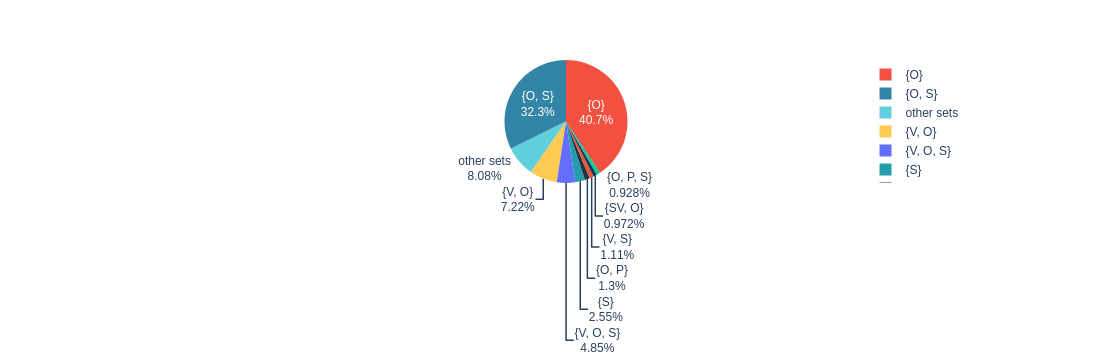

In [23]:
import plotly.express as px
from plotly.colors import label_rgb

names=[]
for name in dbb['disorder_set'].values:
    name_str=str(name).replace("'",'')
    names.append(name_str)
dbb['name']=names

colors=[(242/256, 80/256, 65/256),(11/256, 68/256, 91/256),'lightblue','mediumslateblue','b','royalblue','slateblue','dodgerblue','mediumpurple']

dbb.loc[dbb['percent(max)'] < 0.009, 'name'] = 'other sets' # Represent only large countries
fig = px.pie(dbb, values='percent(max)', names='name', color='name',
             color_discrete_map={"{O}": label_rgb((242, 80, 65)),
                                 "{O, S}": label_rgb((51, 133, 167)),
                                 "{O, V}": label_rgb((11, 68, 91)),
                                 "{O, V, S}": label_rgb((97, 207, 219)),
                                 "{S}": label_rgb((38, 157, 172)),
                                 "{O, P}":label_rgb((34,51, 67)),
                                 "{S, V}": label_rgb((54, 108, 174)),
                                 "{SV, O}": label_rgb((27,54,87)),
                                 'other sets':label_rgb((97, 207,219))
                                  })
fig.update_traces(textinfo='percent+label')
# fig.update_layout(font=dict(size=90))
# fig.write_image("images/set_with_no_duplicates1.png",width=15*300, height=10*300, scale=1)
fig.show()


In [24]:
np.sum(dbb['percent(max)'].values[:30]),np.sum(dbb['percent(min)'].values[:30])

(0.982697566445673, 0.9833664496075231)

In [25]:
length_min,list_of_sets_min=len_set(dbmin_struct['disorder_set'].values)
length_max,list_of_sets_max=len_set(dbmax_struct['disorder_set'].values)
for s in list_of_sets_max:
    if(s not in list_of_sets_min):
        print(s)

{'SV', 'SP', 'O', 'V', 'SVP', 'S'}
{'SVP', 'VP'}


### 3. Coarse-graining

#### Non-intersecting classes

We defined aggregated classes as: <br>
S=({S}, {O, S}) <br>
V=({V}, {O, V}) <br>
P=({P}, {O, P}) <br>
M=(all other sets).

In [26]:
length,list_of_sets=len_set(dbmax_struct['disorder_set'].values)
len_dis=[]

for dis_set in list_of_sets:
    len_dis.append(len(dbmax_struct.loc[dbmax_struct['disorder_set']==dis_set]))

perc=[]
for x in len_dis:
    perc.append(x/np.sum(len_dis))

daa=pd.DataFrame()
daa['disorder_set']=list_of_sets
daa['size(max)']=len_dis
daa['percent(max)']=perc

daa=daa.sort_values(by=['size(max)'],ascending=False).reset_index(drop=True)
daa.head(7)

disorder_set  size(max)  percent(max)
0          {O}      41370      0.406937
1       {O, S}      32824      0.322874
2       {V, O}       7345      0.072249
3    {V, O, S}       4934      0.048533
4          {S}       2597      0.025545
5       {O, P}       1325      0.013033
6       {V, S}       1124      0.011056

In [27]:
slist=[{'S'},{'O','S'}]
vlist=[{'V'},{'O','V'}]
plist=[{'P'},{'O','P'}]

In [28]:
num_o=daa.loc[daa['disorder_set']=={'O'}]['size(max)'].values[0]
num_o, num_o/np.sum(daa['size(max)'])

(41370, 0.4069367118490685)

In [29]:
num_s=np.sum(daa.loc[daa['disorder_set'].isin(slist)]['size(max)'])
num_s, num_s/np.sum(daa['size(max)'])

(35421, 0.34841927170427495)

In [30]:
num_v=np.sum(daa.loc[daa['disorder_set'].isin(vlist)]['size(max)'])
num_v, num_v/np.sum(daa['size(max)'])

(7437, 0.07315417756880643)

In [31]:
num_p=np.sum(daa.loc[daa['disorder_set'].isin(plist)]['size(max)'])
num_p, num_p/np.sum(daa['size(max)'])

(1337, 0.01315142334402235)

In [32]:
num_m=np.sum(daa['size(max)'])-num_o-num_s-num_v-num_p
num_m, num_m/np.sum(daa['size(max)'])

(16097, 0.15833841553382777)

In [33]:
data={'disorder class':["O ({O})","S ({S},{O,S})","V ({V},{V,O})",'P ({P}, {P,O})','M (all other)'],'size':[41370,35421,7437,1337,16097],'fraction':[0.4069,0.3484,0.0732,0.0132,0.1583]}

In [34]:
table=pd.DataFrame.from_dict(data)
table

disorder class   size  fraction
0         O ({O})  41370    0.4069
1   S ({S},{O,S})  35421    0.3484
2   V ({V},{V,O})   7437    0.0732
3  P ({P}, {P,O})   1337    0.0132
4   M (all other)  16097    0.1583

#### Intersecting Classes

In [35]:
o_set=[]
for s in list_of_sets:
    if('O' in s):
        o_set.append(s)

In [36]:
num_o=np.sum(daa.loc[daa['disorder_set'].isin(o_set)]['size(max)'])
num_o, num_o/np.sum(daa['size(max)'])

(96965, 0.9537978792469163)

In [37]:
s_set=[]
for s in list_of_sets:
    if('S' in s):
        s_set.append(s)
    elif('SP' in s):
        s_set.append(s)
    elif('SV' in s):
        s_set.append(s)
    elif('SVP' in s):
        s_set.append(s)

In [38]:
num_s=np.sum(daa.loc[daa['disorder_set'].isin(s_set)]['size(max)'])
num_s, num_s/np.sum(daa['size(max)'])

(49846, 0.4903110306702603)

In [39]:
v_set=[]
for s in list_of_sets:
    if('V' in s):
        v_set.append(s)
    elif('SV' in s):
        v_set.append(s)
    elif('VP' in s):
        v_set.append(s)
    elif('SVP' in s):
        v_set.append(s)

In [40]:
num_v=np.sum(daa.loc[daa['disorder_set'].isin(v_set)]['size(max)'])
num_v, num_v/np.sum(daa['size(max)'])

(20846, 0.2050520351753851)

In [41]:
p_set=[]
for s in list_of_sets:
    if('P' in s):
        p_set.append(s)
    elif('SP' in s):
        p_set.append(s)
    elif('VP' in s):
        p_set.append(s)
    elif('SVP' in s):
        p_set.append(s)

In [42]:
num_p=np.sum(daa.loc[daa['disorder_set'].isin(p_set)]['size(max)'])
num_p, num_p/np.sum(daa['size(max)'])

(8699, 0.08556786213137652)

In [43]:
data={'disorder class':["O (all comounds with O)","S (all comounds with S, SV, SP, SVP)","V (all compounds with V, SV, VP, SVP)",'P (all compounds with P, SP, VP, SVP)'],'size':[96965, 49846, 20846, 8699],'fraction':[0.954, 0.490, 0.205, 0.086]}
table=pd.DataFrame.from_dict(data)
table

disorder class   size  fraction
0                O (all comounds with O)  96965     0.954
1   S (all comounds with S, SV, SP, SVP)  49846     0.490
2  V (all compounds with V, SV, VP, SVP)  20846     0.205
3  P (all compounds with P, SP, VP, SVP)   8699     0.086

### Sunburst chart

In [44]:
dbb.head(30)

disorder_set  size(max)  percent(max)  size(min)  percent(min)  \
0             {O}      41370      0.406937    42419.0      0.417255   
1          {O, S}      32824      0.322874    32607.0      0.320739   
2          {V, O}       7345      0.072249     7131.0      0.070144   
3       {V, O, S}       4934      0.048533     4886.0      0.048061   
4             {S}       2597      0.025545     2542.0      0.025004   
5          {O, P}       1325      0.013033     1146.0      0.011273   
6          {V, S}       1124      0.011056     1113.0      0.010948   
7         {SV, O}        988      0.009718      980.0      0.009640   
8       {O, P, S}        943      0.009276      895.0      0.008804   
9       {V, P, O}        776      0.007633      716.0      0.007043   
10     {SV, O, S}        759      0.007466      747.0      0.007348   
11        {O, SP}        635      0.006246      628.0      0.006177   
12     {O, SP, S}        523      0.005144      512.0      0.005036   
13     {SV, O, V}        498      0.004899      480.0      0.004722   
14     {O, VP, S}        370      0.003640      362.0      0.003561   
15     {O, V, VP}        341      0.003354      323.0      0.003177   
16   {O, V, P, S}        328      0.003226      327.0      0.003217   
17     {V, O, SP}        302      0.002971      300.0      0.002951   
18  {O, V, VP, S}        266      0.002617      263.0      0.002587   
19        {O, VP}        248      0.002439      237.0      0.002331   
20     {O, P, SP}        205      0.002016      183.0      0.001800   
21  {O, V, SP, S}        165      0.001623      159.0      0.001564   
22  {SV, O, V, S}        154      0.001515      170.0      0.001672   
23     {O, P, VP}        143      0.001407      135.0      0.001328   
24         {P, S}        142      0.001397      140.0      0.001377   
25  {O, P, SP, S}        137      0.001348      133.0      0.001308   
26  {V, P, O, VP}        131      0.001289      132.0      0.001298   
27        {SV, V}        124      0.001220      117.0      0.001151   
28  {O, V, P, SP}        114      0.001121      113.0      0.001112   
29            {V}         92      0.000905       75.0      0.000738   

          name  
0          {O}  
1       {O, S}  
2       {V, O}  
3    {V, O, S}  
4          {S}  
5       {O, P}  
6       {V, S}  
7      {SV, O}  
8    {O, P, S}  
9   other sets  
10  other sets  
11  other sets  
12  other sets  
13  other sets  
14  other sets  
15  other sets  
16  other sets  
17  other sets  
18  other sets  
19  other sets  
20  other sets  
21  other sets  
22  other sets  
23  other sets  
24  other sets  
25  other sets  
26  other sets  
27  other sets  
28  other sets  
29  other sets

In [45]:
plist=[{'P','O'},{'P'}]
slist=[{'S','O'},{'S'}]
vlist=[{'V','O'},{'V'}]
olist=[{'O'}]



a=dbb['disorder_set']
c=list(dbb['percent(max)'])
b=[]
for x in a:
    s=str(x)
    s=s.replace("'",'')
    b.append(s)

bb=['ICSD']
cc=[""]
xx=[1.0]
colors=[label_rgb((11, 68, 91))]
# colors=[label_rgb((54, 108, 174))]

bb.append('Ordered')
cc.append('ICSD')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'O'}]['percent(max)'].values))
colors.append(label_rgb((242, 80, 65)))

bb.append('Disordered')
cc.append('ICSD')
xx.append(sum(dbb.loc[dbb['disorder_set']!={'O'}]['percent(max)'].values))
colors.append(label_rgb((38, 157, 172)))

bb.append("O")
cc.append('Ordered')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'O'}]['percent(max)'].values))
colors.append('salmon')

bb.append('S')
cc.append('Disordered')
xx.append(sum(dbb.loc[dbb['disorder_set'].isin(slist)]['percent(max)'].values))
colors.append('purple')

bb.append('V')
cc.append('Disordered')
xx.append(sum(dbb.loc[dbb['disorder_set'].isin(vlist)]['percent(max)'].values))
colors.append('lightblue')

bb.append('P')
cc.append('Disordered')
xx.append(sum(dbb.loc[dbb['disorder_set'].isin(plist)]['percent(max)'].values))
colors.append('skyblue')

bb.append('M')
cc.append('Disordered')
xx.append(sum(dbb.loc[~dbb['disorder_set'].isin(olist+plist+slist+vlist)]['percent(max)'].values))
colors.append('mediumslateblue')

bb.append('{S}')
cc.append('S')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'S'}]['percent(max)'].values))
colors.append('purple')

bb.append('{S, O}')
cc.append('S')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'S','O'}]['percent(max)'].values))
colors.append('purple')

bb.append('{P}')
cc.append('P')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'P'}]['percent(max)'].values))
colors.append('skyblue')

bb.append('{P, O}')
cc.append('P')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'P','O'}]['percent(max)'].values))
colors.append('skyblue')

bb.append('{V}')
cc.append('V')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'V'}]['percent(max)'].values))
colors.append('lightblue')

bb.append('{V, O}')
cc.append('V')
xx.append(sum(dbb.loc[dbb['disorder_set']=={'V','O'}]['percent(max)'].values))
colors.append('lightblue')

for x in dbb['disorder_set'].values:
    if(x not in vlist+slist+plist+olist):
        s=str(x)
        s=s.replace("'","")
        bb.append(s)
        cc.append('M')
        xx.append(sum(dbb.loc[dbb['disorder_set']==x]['percent(max)'].values))
        colors.append('mediumslateblue')



In [46]:
len(bb),len(cc),len(xx),len(colors)

(177, 177, 177, 177)

In [47]:
import plotly.express as px
data1 = dict(
    character=bb,
    parent=cc,
    value=xx)

fig = px.sunburst(
    data1,
    names='character',
    parents='parent',
    values='value',
    branchvalues="total", #template='plotly'
    color_discrete_sequence=colors
   
)

fig.update_layout(margin = dict(t=20, l=0, r=0, b=2),font=dict(size=100))
# fig.update_traces(textinfo="label+percent parent")
# color_discrete_sequence=px.colors.sequential.RdBu
fig.update_traces(textinfo="label+percent parent")
# fig.update_traces(textinfo='character+value')
# # fig.add_annotation(textangle=[0, 0, 0,0, 0, 0, 0, 0,0,0])
fig.write_image("images/set_with_no_duplicates_disordered.png",width=15*300, height=10*300, scale=1)
fig.show()

In [48]:
dcc=dbb.copy()

dis=[]
dis_class=[]
for i in dcc['disorder_set'].values:
    if(i=={'O'}):
        dis.append('Ordered')
        dis_class.append('O')
    else:
        dis.append('Disordered')
        if(i in slist):
            dis_class.append('S')
        elif(i in vlist):
            dis_class.append('V')
        elif(i in plist):
            dis_class.append('P')
        else:
            dis_class.append('M')
dcc['disorder']=dis
dcc['dis_class']=dis_class

a=dcc['disorder_set']
b=[]
for x in a:
    s=str(x)
    s=s.replace("'",'')
    b.append(s)
dcc['disorder_set']=b

In [49]:
dcc

disorder_set  size(max)  percent(max)  size(min)  \
0                        {O}      41370      0.406937    42419.0   
1                     {O, S}      32824      0.322874    32607.0   
2                     {V, O}       7345      0.072249     7131.0   
3                  {V, O, S}       4934      0.048533     4886.0   
4                        {S}       2597      0.025545     2542.0   
..                       ...        ...           ...        ...   
165         {SVP, O, VP, SP}          1      0.000010        1.0   
166        {P, SP, O, V, SV}          1      0.000010        1.0   
167         {SVP, V, VP, SP}          1      0.000010        1.0   
168       {P, SP, V, VP, SV}          1      0.000010        1.0   
169  {SV, SP, O, V, VP, SVP}          1      0.000010        1.0   

     percent(min)        name    disorder dis_class  
0        0.417255         {O}     Ordered         O  
1        0.320739      {O, S}  Disordered         S  
2        0.070144      {V, O}  Disordered         V  
3        0.048061   {V, O, S}  Disordered         M  
4        0.025004         {S}  Disordered         S  
..            ...         ...         ...       ...  
165      0.000010  other sets  Disordered         M  
166      0.000010  other sets  Disordered         M  
167      0.000010  other sets  Disordered         M  
168      0.000010  other sets  Disordered         M  
169      0.000010  other sets  Disordered         M  

[170 rows x 8 columns]

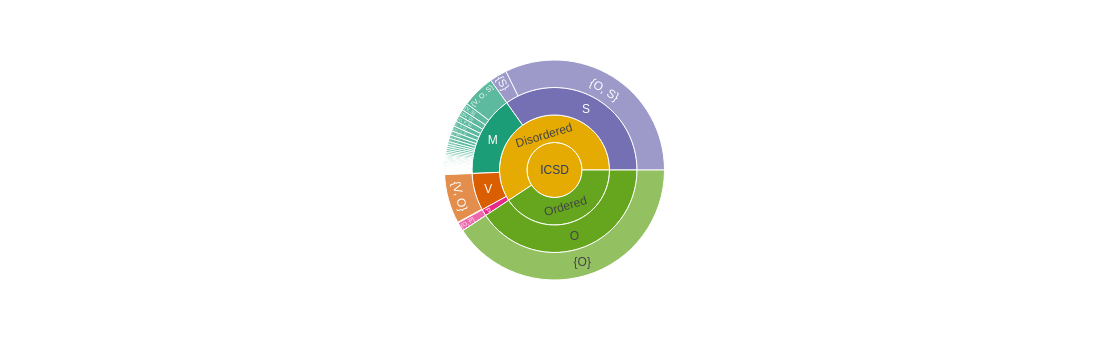

In [50]:
import plotly.express as px

fig = px.sunburst(dcc, path=[px.Constant("ICSD"),'disorder', 'dis_class', 'disorder_set'], values='percent(max)',\
                  color='dis_class',color_discrete_sequence=px.colors.qualitative.Dark2)
fig.show()

/tmp/ipykernel_9559/1446154313.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



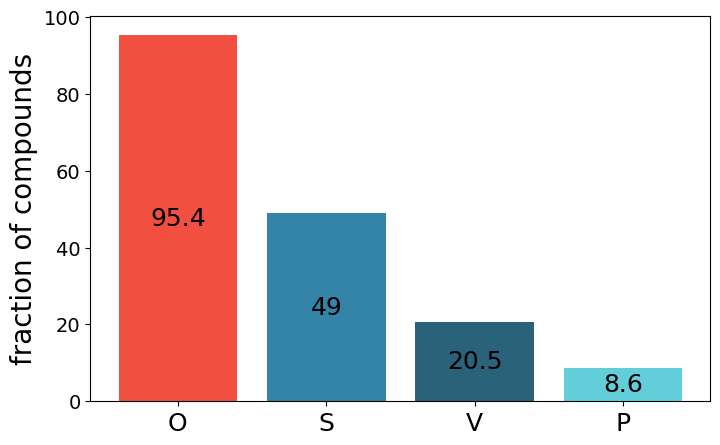

In [51]:
names=['O','S','V','P']
percent=[0,0,0,0]
inter_class_O=[]
inter_class_S=[]
inter_class_V=[]
inter_class_P=[]
for i in range(len(dbb)):
    if('O' in dbb.iloc[i]['disorder_set']):
        percent[0]+=dbb.iloc[i]['percent(max)']
        inter_class_O.append(True)
    else:
        inter_class_O.append(False)
    if(('S' in dbb.iloc[i]['disorder_set']) or ('SV' in dbb.iloc[i]['disorder_set']) or\
       ('SP' in dbb.iloc[i]['disorder_set']) or ('SVP' in dbb.iloc[i]['disorder_set'])):
        percent[1]+=dbb.iloc[i]['percent(max)']
        inter_class_S.append(True)
    else:
        inter_class_S.append(False)
    if(('V' in dbb.iloc[i]['disorder_set']) or ('SV' in dbb.iloc[i]['disorder_set']) or\
       ('VP' in dbb.iloc[i]['disorder_set']) or ('SVP' in dbb.iloc[i]['disorder_set'])):
        percent[2]+=dbb.iloc[i]['percent(max)']
        inter_class_V.append(True)
    else:
        inter_class_V.append(False)
    if(('P' in dbb.iloc[i]['disorder_set']) or ('SP' in dbb.iloc[i]['disorder_set']) or\
       ('VP' in dbb.iloc[i]['disorder_set']) or ('SVP' in dbb.iloc[i]['disorder_set'])):
        percent[3]+=dbb.iloc[i]['percent(max)']
        inter_class_P.append(True)
    else:
        inter_class_P.append(False)
for i in range(4):
    percent[i]=round(percent[i],3)*100

fig, ax = plt.subplots(figsize=(8,5))
p = ax.bar(names, percent, width=0.8, label=percent, color=[(242/256, 80/256, 65/256),(51/256, 133/256, 167/256),(41/256, 98/256, 121/256),(97/256, 207/256,219/256)])
ax.bar_label(p, label_type='center',fontsize=18)
ax.set_xticklabels(labels=names,fontsize=18)
plt.ylabel('fraction of compounds',fontsize=20)
plt.yticks(fontsize=14)
plt.savefig("images/intersecting_classes.png", transparent=True, dpi=400, format='png')
plt.show()

/tmp/ipykernel_9559/2788781783.py:30: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



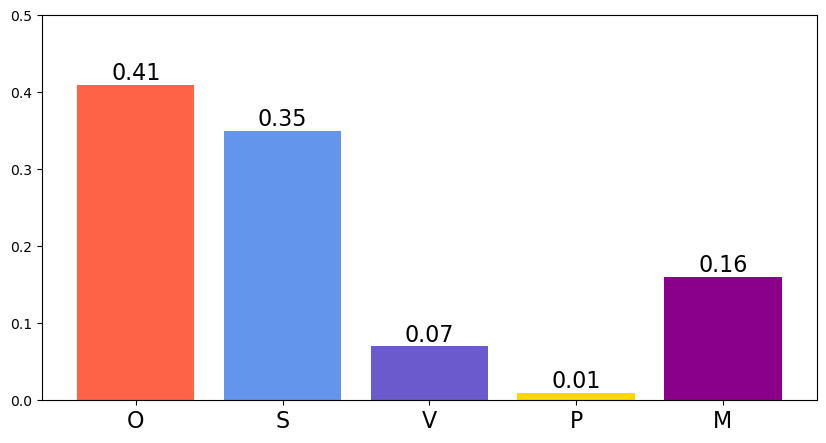

In [52]:
plist=[{'P','O'},{'P'}]
slist=[{'S','O'},{'S'}]
vlist=[{'V','O'},{'V'}]
olist=[{'O'}]

names=['O','S','V','P','M']
percent=[0,0,0,0,0]
non_intersecting_class=[]
for i in range(len(dbb)):
    if(dbb.iloc[i]['disorder_set'] in olist):
        percent[0]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('O')
    elif(dbb.iloc[i]['disorder_set'] in slist):
        percent[1]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('S')
    elif(dbb.iloc[i]['disorder_set'] in vlist):
        percent[2]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('V')
    elif(dbb.iloc[i]['disorder_set'] in plist):
        percent[3]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('P')
    else:
        percent[4]+=dbb.iloc[i]['percent(max)']
        non_intersecting_class.append('M')
for i in range(5):
    percent[i]=round(percent[i],2)
fig, ax = plt.subplots(figsize=(10,5))
p = ax.bar(names, percent, width=0.8, label=percent, color=['tomato','cornflowerblue','slateblue','gold','darkmagenta'])
ax.bar_label(p,fontsize=16)
ax.set_xticklabels(labels=names,fontsize=16)
plt.ylim(0,0.5)
plt.savefig("images/non-intersecting_classes.png", transparent=True, dpi=400, format='png')

plt.show()

In [53]:
dbb['names']=b

In [54]:
dbb['non_intersecting']=non_intersecting_class
dbb['O']=inter_class_O
dbb['S']=inter_class_S
dbb['V']=inter_class_V
dbb['P']=inter_class_P
dbb

disorder_set  size(max)  percent(max)  size(min)  \
0                        {O}      41370      0.406937    42419.0   
1                     {O, S}      32824      0.322874    32607.0   
2                     {V, O}       7345      0.072249     7131.0   
3                  {V, O, S}       4934      0.048533     4886.0   
4                        {S}       2597      0.025545     2542.0   
..                       ...        ...           ...        ...   
165         {SVP, O, VP, SP}          1      0.000010        1.0   
166        {P, SP, O, V, SV}          1      0.000010        1.0   
167         {SVP, V, VP, SP}          1      0.000010        1.0   
168       {P, SP, V, VP, SV}          1      0.000010        1.0   
169  {SV, SP, O, V, VP, SVP}          1      0.000010        1.0   

     percent(min)        name                    names non_intersecting  \
0        0.417255         {O}                      {O}                O   
1        0.320739      {O, S}                   {O, S}                S   
2        0.070144      {V, O}                   {V, O}                V   
3        0.048061   {V, O, S}                {V, O, S}                M   
4        0.025004         {S}                      {S}                S   
..            ...         ...                      ...              ...   
165      0.000010  other sets         {SVP, O, VP, SP}                M   
166      0.000010  other sets        {P, SP, O, V, SV}                M   
167      0.000010  other sets         {SVP, V, VP, SP}                M   
168      0.000010  other sets       {P, SP, V, VP, SV}                M   
169      0.000010  other sets  {SV, SP, O, V, VP, SVP}                M   

         O      S      V      P  
0     True  False  False  False  
1     True   True  False  False  
2     True  False   True  False  
3     True   True   True  False  
4    False   True  False  False  
..     ...    ...    ...    ...  
165   True   True   True   True  
166   True   True   True   True  
167  False   True   True   True  
168  False   True   True   True  
169   True   True   True   True  

[170 rows x 12 columns]

# Global order/disorder

In [55]:
numbers=[]
ordered=[]
ordered_n=[]
disordered=[]
disordered_n=[]
for n in range(1,15):
    dx=dbmax_struct.loc[dbmax_struct['num_el']==n]
    numbers.append(len(dx))
    if(len(dx)>0):
        o=dx.loc[dx['disorder_set']=={'O'}]
        ordered_n.append(len(o)/10000)
        ordered.append(len(o)/len(dx))
        d=dx.loc[dx['disorder_set']!={'O'}]
        disordered_n.append(len(d)/10000)
        disordered.append(len(d)/len(dx))
    else:
        ordered_n.append(0)
        ordered.append(0)
        disordered_n.append(0)
        disordered.append(0)


In [56]:
len(dbmax_struct)

101662

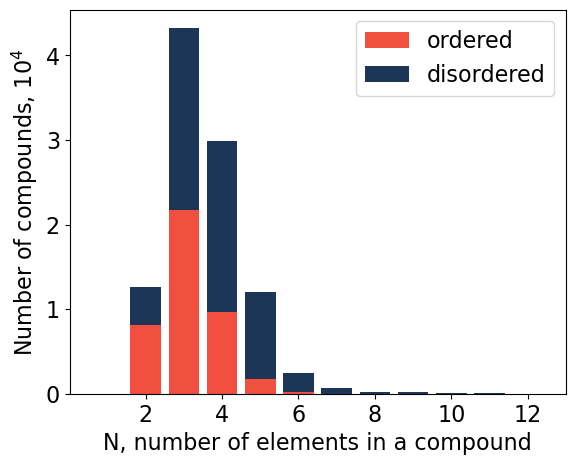

In [57]:
plt.bar(np.linspace(1,12,12),ordered_n[:-2],label='ordered',color=(242/256, 80/256, 65/256))
plt.bar(np.linspace(1,12,12),disordered_n[:-2],bottom=ordered_n[:-2],label='disordered',color=(27/256,54/256,87/256))
plt.xlabel('N, number of elements in a compound',fontsize=16)
plt.ylabel('Number of compounds, $10^4$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=False)
# plt.yscale('log')
plt.legend(fontsize=16)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/comp_distr.png', transparent=None, dpi=400, format='png')
plt.show()

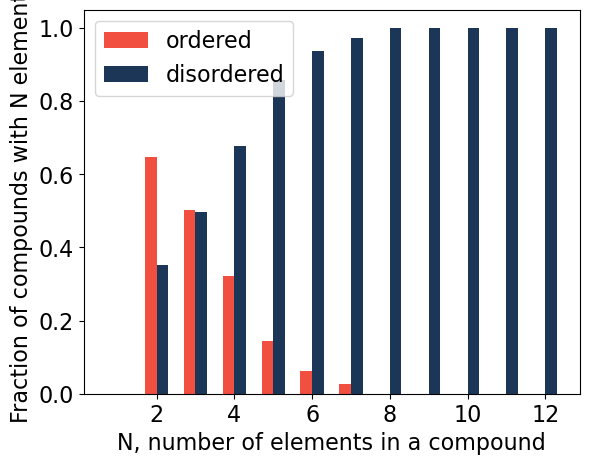

In [58]:
plt.bar(np.linspace(1-0.15,12-0.15,12),ordered[:-2],width=0.3,label='ordered',color=(242/256, 80/256, 65/256))
plt.bar(np.linspace(1+0.15,12+0.15,12),disordered[:-2],width=0.3,label='disordered',color=(27/256,54/256,87/256))
plt.xlabel('N, number of elements in a compound',fontsize=16)
plt.ylabel('Fraction of compounds with N elements',fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=False)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/order-vs-disorder.png', transparent=None, dpi=400, format='png')
plt.show()

/home/tessa/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning:

Mean of empty slice.

/home/tessa/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning:

invalid value encountered in scalar divide

/home/tessa/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/tessa/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/_core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/home/tessa/anaconda3/envs/disorder/lib/python3.11/site-packages/numpy/_core/_methods.py:219: RuntimeWarning:

invalid value encountered in scalar divide



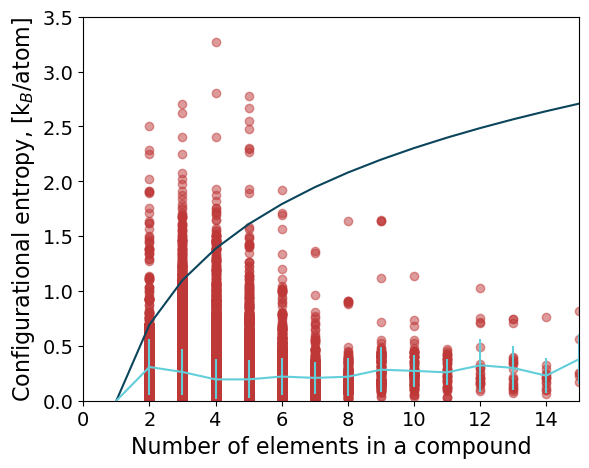

In [59]:
means=[0]
stds=[0]

dbmax_nona=dbmax_struct.loc[~dbmax_struct['conf_entropy'].isna()]
dbmax_nona=dbmax_nona.loc[dbmax_nona['conf_entropy']<100]
dbmax_nona=dbmax_nona.loc[dbmax_nona['conf_entropy']>0]
for n in range(2,31):
    ent=dbmax_nona.loc[dbmax_nona['num_el']==n]['conf_entropy'].values
    means.append(np.mean(ent))
    stds.append(np.std(ent))

plt.scatter(dbmax_nona['num_el'], dbmax_nona['conf_entropy'], alpha=0.5,color=(192/256, 56/256, 56/256))
plt.errorbar(np.linspace(1,30,30), means, yerr=stds, alpha=1,color=(97/256, 207/256, 219/256))

# plt.bar(np.linspace(1,14,14), stds, alpha=0.5, width=0.3)
plt.plot(np.linspace(1,30,30), np.log(np.linspace(1,30,30)),color=(11/256, 69/256, 92/256))

plt.xlim(0,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=True)
#plt.ylim(0.0001,10)
#plt.yscale('log')
plt.ylim(-0.0001,3.5)
plt.xlabel('Number of elements in a compound',fontsize=16)
plt.ylabel('Configurational entropy, [k$_B$/atom]', fontsize=16)
plt.grid(visible=False)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/entropy-num-elem-no0.png', transparent=None, dpi=400, format='png')
plt.show()

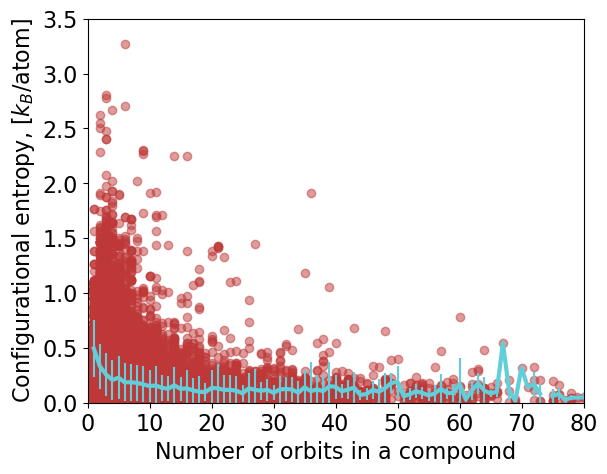

In [60]:
means=[]
stds=[]

dbmax_nona=dbmax_struct.loc[~dbmax_struct['conf_entropy'].isna()]
dbmax_nona=dbmax_nona.loc[dbmax_nona['conf_entropy']<100]
dbmax_nona=dbmax_nona.loc[dbmax_nona['conf_entropy']>0]
#for n in range(1,101):
#    ent=dbmax_nona.loc[dbmax_nona['num_orb']==n]['conf_entropy'].values
#    ent1=dbmax_nona.loc[dbmax_nona['num_orb']==n]['mixing_entropy'].values
#    means.append(np.mean(ent-ent1))
#    stds.append(np.std(ent-ent1))

for n in range(1,101):
    ent=dbmax_nona.loc[dbmax_nona['num_orb']==n]['conf_entropy'].values
    means.append(np.mean(ent))
    stds.append(np.std(ent))
    
# plt.scatter(dbmax_nona['num_orb'], dbmax_nona['conf_entropy'].values, alpha=0.5,color=(192/256, 56/256, 56/256))

plt.scatter(dbmax_nona['num_orb'], dbmax_nona['conf_entropy'].values, alpha=0.5,color=(192/256, 56/256, 56/256))
#plt.bar(np.linspace(1,200,200), means, alpha=1, width=0.3)
plt.errorbar(np.linspace(1,100,100), means, yerr=stds, alpha=1,color=(97/256, 207/256, 219/256))

plt.plot(np.linspace(1,100,100), means, alpha=1,color=(97/256, 207/256, 219/256),linewidth=3)
plt.xlim(0,80)
plt.ylim(0,2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log') 
#plt.ylim(0.005,5)
plt.ylim(-0.001,3.5)
plt.grid(visible=False)
plt.xlabel('Number of orbits in a compound',fontsize=16)
plt.ylabel('Configurational entropy, [$k_B$/atom]', fontsize=16)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/entropy-num-orb-lin-no0_lin.png', transparent=None, dpi=400, format='png')
plt.show()

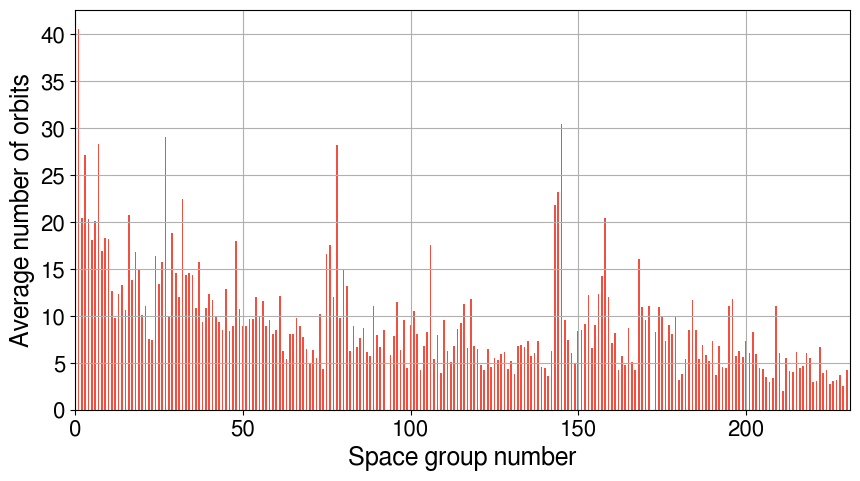

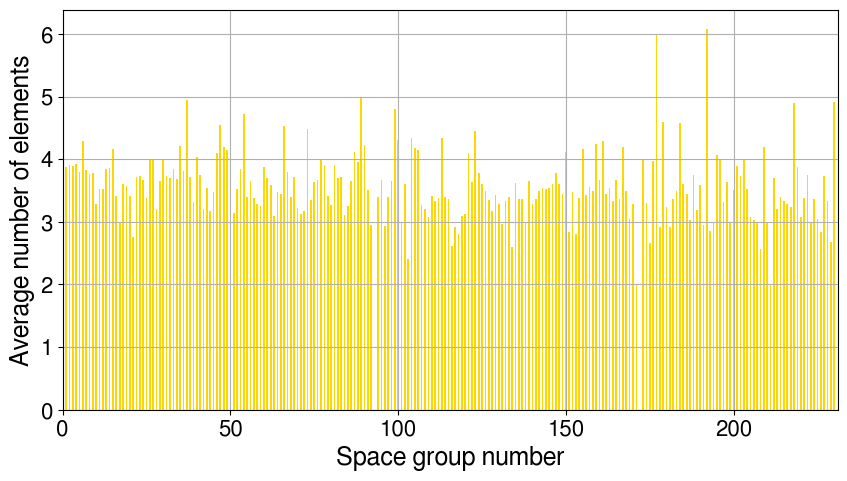

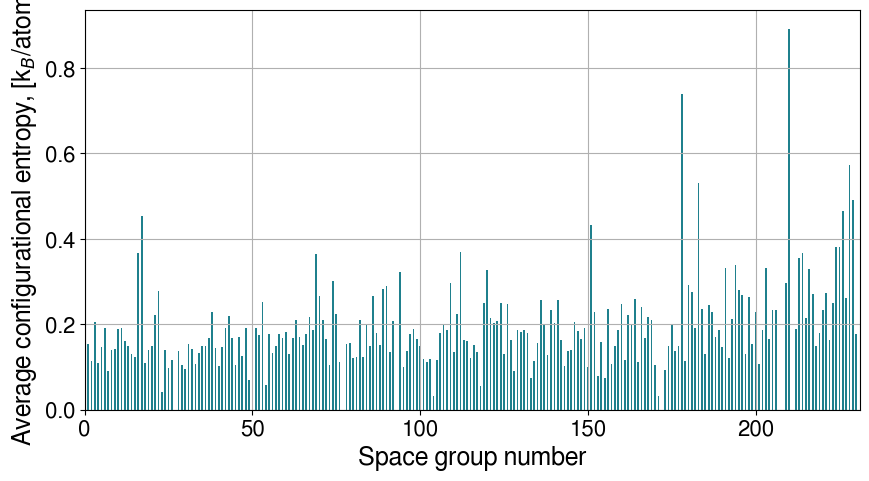

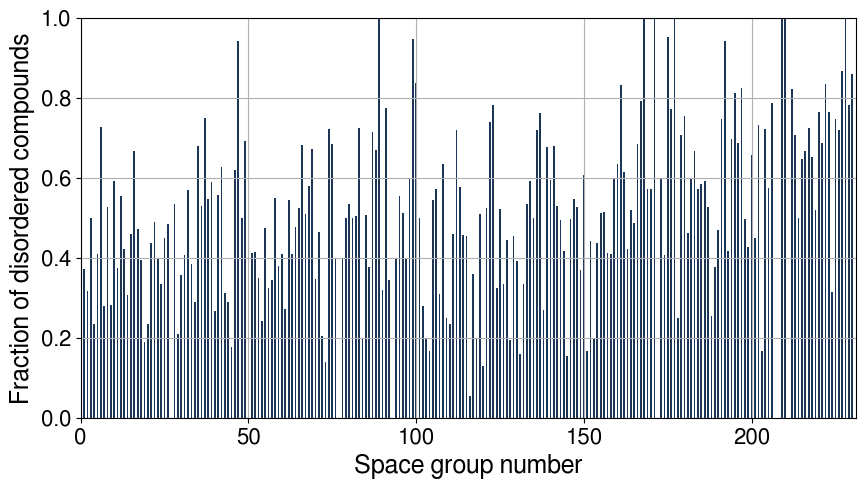

In [61]:
dbmax_nona=dbmax_struct.loc[~dbmax_struct['conf_entropy'].isna()]
dbmax_nona=dbmax_nona.loc[dbmax_nona['conf_entropy']<100]
space_groups=np.linspace(1,230,230,dtype='int')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'FreeSans'

space_num_orb=[]
for group in space_groups:
    dx=dbmax_struct.loc[dbmax_struct['group_num']==group]
    space_num_orb.append(np.mean(dx['num_orb'].values))

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_num_orb,color=(242/256, 80/256, 65/256), width=0.5)
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Average number of orbits', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,231)
plt.grid(visible=True)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/av-orbits-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

space_num_elem=[]
for group in space_groups:
    dx=dbmax_struct.loc[dbmax_struct['group_num']==group]
    space_num_elem.append(np.mean(dx['num_el'].values))

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_num_elem,color='gold', width=0.5)
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Average number of elements', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,231)
plt.grid(visible=True)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/av-elem-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

space_num_entropy=[]
dbmax_nona1=dbmax_nona.loc[dbmax_nona['disorder_set']!={'O'}]
for group in space_groups:
    dx=dbmax_nona1.loc[dbmax_nona1['group_num']==group]
    space_num_entropy.append(np.mean(dx['conf_entropy'].values))

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_num_entropy,color=(31/256, 129/256, 142/256), width=0.5)
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Average configurational entropy, [k$_B$/atom]   ', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,231)
plt.grid(visible=True)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/av-entropy-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

space_frac_dis=[]
for group in space_groups:
    dx=dbmax_struct.loc[dbmax_struct['group_num']==group]
    if(len(dx)>0):
        space_frac_dis.append(len(dx.loc[dx['disorder_set']!={'O'}])/len(dx))
    else:
        space_frac_dis.append(0)

plt.figure(figsize=(10,5))
plt.bar(space_groups,space_frac_dis,color=(27/256,54/256,87/256), width=0.5)
plt.xlabel('Space group number',fontsize=18)
plt.ylabel('Fraction of disordered compounds', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,231)
plt.ylim(0,1)
plt.grid(visible=True)
plt.subplots_adjust(bottom=0.14, top=0.94)
plt.savefig('images/frac-order-space-group.png', transparent=None, dpi=400, format='png')
plt.show()

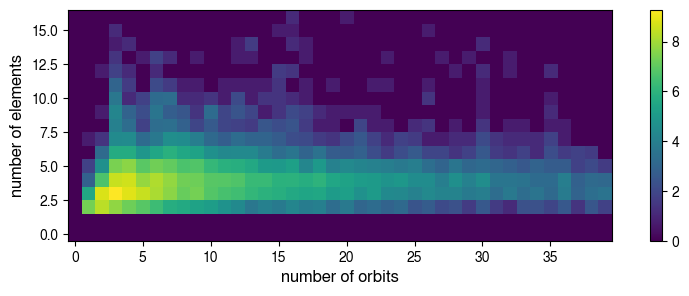

In [62]:
orb_vs_el=np.zeros((17,40))

for i in range(40):
    for j in range(17):
        dx=dbmax_struct.loc[dbmax_struct['num_orb']==i]
        dy=dx.loc[dx['num_el']==j]
        orb_vs_el[j,i]=np.log(1+len(dy))

plt.figure(figsize=(10,3))
plt.imshow(orb_vs_el,origin='lower')
plt.colorbar()
plt.xlabel('number of orbits',fontsize=12)
plt.ylabel('number of elements',fontsize=12)
plt.show()

In [145]:
orb_el_comp=[]
for i in range(len(dbmax_struct)):
    comp_el=[]
    for i,orb in dbmax_struct.iloc[i]['species'].items():
        c_el=[]
        comp=Composition(orb).element_composition.elements
        for el in comp:
            c_el.append(str(el))
        comp_el.append(c_el)
    orb_el_comp.append(comp_el)


In [146]:
dbmax_struct['orbit_elements_comp']=orb_el_comp

/tmp/ipykernel_9559/811565596.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Distribution of disorder over the elements


### General distribution over elements

In [147]:
elem_list=['Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P',
           'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

In [148]:
len(elem_list)

96

In [149]:
element_disorder=dbmax_struct[['ICSD_ID','formula','disorder_set','orbit_disorder','orbit_elements_comp']]

In [150]:
def calculate_elements(elem_list,element_disorder):
    elem_disorder={}
    
    for key in elem_list:
        # the correspondence between the number in element vector and disorder is 
        # [O-0,S-1,V-2,P-3,SV-4,SP-5,VP-6,SVP-7]
        elem_disorder[key]=np.zeros(8)
    for i in range(len(element_disorder)):
        order=element_disorder['orbit_disorder'].values[i]
        elem=element_disorder['orbit_elements_comp'].values[i]
        elem_dict={}
        for j,el_list in enumerate(elem):
            for el in el_list:
                if(el in elem_dict.keys()):
                    elem_dict[el].append(order[str(j)])
                else:
                    elem_dict[el]=[order[str(j)]]
        for key in elem_dict.keys():
            states=list(set(elem_dict[key]))
            switch={'O':0,'S':0,'P':0,'V':0,'SV':0,'SP':0,'VP':0,'SVP':0}
            for s in states:
                if(key in elem_list):
                    if(s=='O' and switch['O']==0):
                        elem_disorder[key][0]+=1
                        switch['O']=1
                    elif(s=='S' and switch['S']==0):
                        elem_disorder[key][1]+=1
                        switch['S']=1
                    elif(s=='V' and switch['V']==0):
                        elem_disorder[key][2]+=1
                        switch['V']=1
                    elif(s=='P' and switch['P']==0):
                        elem_disorder[key][3]+=1
                        switch['P']=1
                    elif(s=='SV' and switch['SV']==0):
                        elem_disorder[key][4]+=1
                        switch['SV']=1
                    elif(s=='SP' and switch['SP']==0):
                        elem_disorder[key][5]+=1
                        switch['SP']=1
                    elif(s=='VP' and switch['VP']==0):
                        elem_disorder[key][6]+=1
                        switch['VP']=1
                    elif(s=='SVP' and switch['SVP']==0):
                        elem_disorder[key][7]+=1
                        switch['SVP']=1

    elem_disorder_frac={}
    total_values=[]
    frac_values=[]
    for key in elem_disorder.keys():
        elem_disorder_frac[key]=np.zeros(9)
        elem_disorder_frac[key][0]=np.sum(elem_disorder[key])
        total_values.append(elem_disorder_frac[key][0])
        if(elem_disorder_frac[key][0]!=0):
            for i in range(1,9):
                elem_disorder_frac[key][i]=elem_disorder[key][i-1]/elem_disorder_frac[key][0]
        frac_values.append(elem_disorder_frac[key][1:9])
    
    return elem_disorder, elem_disorder_frac

In [151]:
elem_disorder, elem_disorder_frac=calculate_elements(elem_list,element_disorder)

In [152]:
def bars_fill(elem_disorder,frac=True):
    bars=np.zeros((8,len(elem_disorder.keys())))
    total=[]
    names=[]
    r=[]
    for i,key in enumerate(elem_disorder.keys()):
        names.append(key)
        if(frac==True):
            for j in range(0,8):
                bars[j,i]=elem_disorder[key][1+j]
        else:
            for j in range(0,8):
                bars[j,i]=elem_disorder[key][j]
            
        total.append(int(np.sum(elem_disorder[key])))
        r.append(i)
    bottom3=np.zeros((6,len(elem_disorder.keys())))
    bottom3[0,:]=bars[0,:]+bars[1,:]
    for i in range(5):
        bottom3[i+1,:]=bottom3[i,:]+bars[i+2,:]
    return bars, total, names, r, bottom3

In [153]:
def plot_elements(elem_disorder,filename, n=58, frac=True,barWidth=1): 
    bars, total, names, r, bottom3 = bars_fill(elem_disorder,frac)
    
    
    if(frac==True):
        caption='fraction of compounds'
    else:
        caption='number of compounds'
    
    plt.figure(figsize=(15,10))

    # Create brown bars
    ax1=plt.subplot(211)
    ax2=ax1.twiny()
    
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[0,:n], color=(242/256, 80/256, 65/256), edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[1,:n], bottom=bars[0,:n], color=(51/256, 120/256, 170/256), edgecolor='white', width=barWidth,label='S')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[2,:n], bottom=bottom3[0,:n], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label='V')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[3,:n], bottom=bottom3[1,:n], color=(229/256, 226/256, 89/256), edgecolor='white', width=barWidth,label='P')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[4,:n], bottom=bottom3[2,:n], color=(209/256, 119/256, 99/256), edgecolor='white', width=barWidth,label='SV')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[5,:n], bottom=bottom3[3,:n], color=(192/256, 56/256, 56/256), edgecolor='white', width=barWidth,label='SP') 
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[6,:n], bottom=bottom3[4,:n], color='green', edgecolor='white', width=barWidth,label='VP')
    ax1.bar(r[:n]+0.5*np.ones(len(r[:n])), bars[7,:n], bottom=bottom3[5,:n], color='black', edgecolor='white', width=barWidth,label='SVP')


    # Custom X axis
    ax1.set_xticks(r[:n]+0.5*np.ones(len(r[:n])), names[:n], fontweight='bold',fontsize=10)
    # plt.xlabel("element",fontweight='bold',fontsize=12)
    ax1.set_ylabel(caption,fontweight='bold',fontsize=16)
    ax1.grid(visible=False,axis='both')

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(r[:n]+0.5*np.ones(len(r[:n])))
    ax2.set_xticklabels(total[:n],rotation='vertical')
    ax2.grid(visible=False)
#     ax1.legend()

    ax1=plt.subplot(212)
    ax2=ax1.twiny()
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[0,n:], color=(242/256, 80/256, 65/256), edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[1,n:], bottom=bars[0,n:], color=(51/256, 120/256, 170/256), edgecolor='white', width=barWidth,label='S')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[2,n:], bottom=bottom3[0,n:], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label='V')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[3,n:], bottom=bottom3[1,n:], color=(229/256, 226/256, 89/256), edgecolor='white', width=barWidth,label='P')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[4,n:], bottom=bottom3[2,n:], color=(209/256, 119/256, 99/256), edgecolor='white', width=barWidth,label='SV')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[5,n:], bottom=bottom3[3,n:], color=(192/256, 56/256, 56/256), edgecolor='white', width=barWidth,label='SP') 
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[6,n:], bottom=bottom3[4,n:], color='green', edgecolor='white', width=barWidth,label='VP')
    ax1.bar(r[n:]+0.5*np.ones(len(r[n:])), bars[7,n:], bottom=bottom3[5,n:], color='black', edgecolor='white', width=barWidth,label='SVP')

    # Custom X axis
    ax1.set_xticks(r[n:]+0.5*np.ones(len(r[n:])), names[n:], fontweight='bold',fontsize=10)
    # plt.xlabel("element",fontweight='bold',fontsize=12)
    ax1.set_ylabel(caption,fontweight='bold',fontsize=16)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(r[n:]+0.5*np.ones(len(r[n:])))
    ax2.set_xticklabels(total[n:],rotation='vertical')
    ax2.grid(visible=False)
    ax1.grid(visible=False,axis='both')
    ax1.legend()
    # Show graphic
    path='images/'
    plt.savefig(filename, transparent=None, dpi=400, format='png')
    # plt.show()

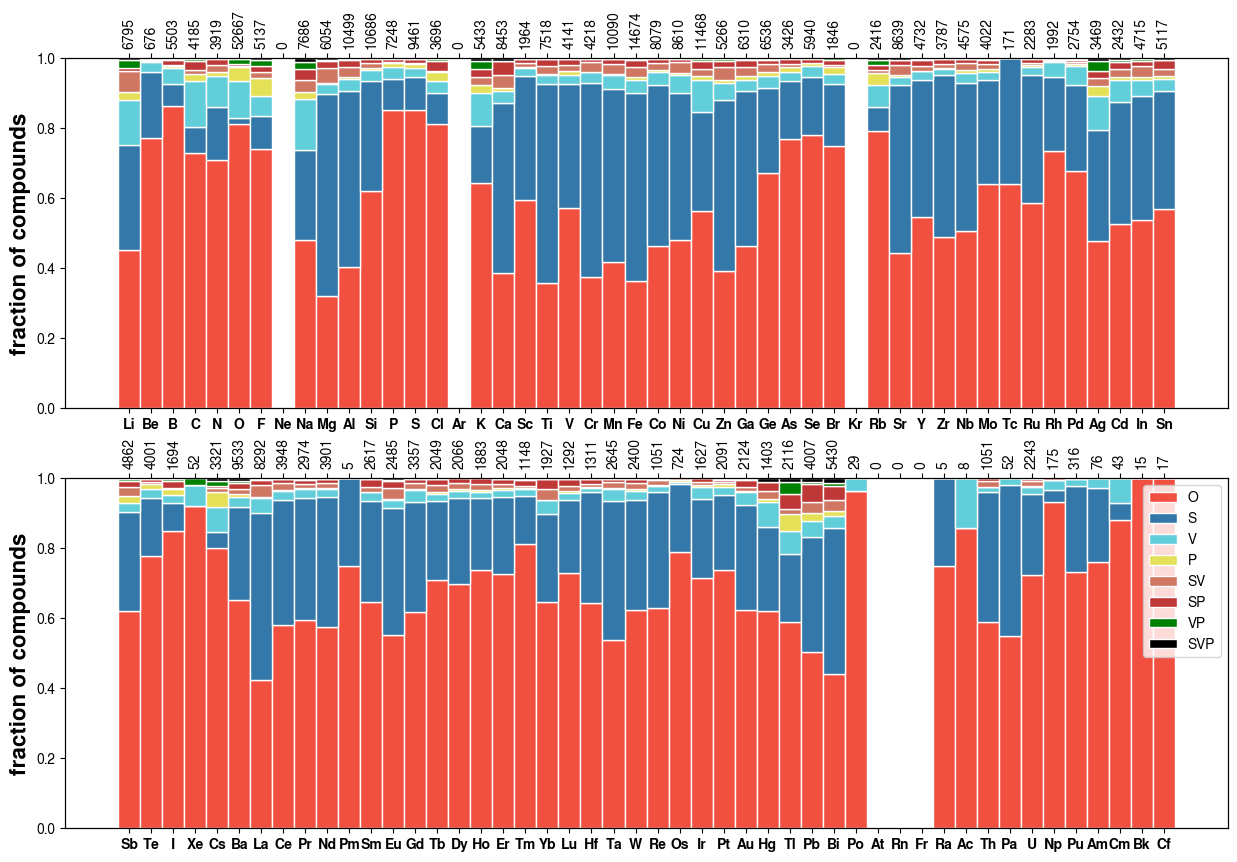

In [154]:
plot_elements(elem_disorder_frac,filename='distr-over-elements.png', n=48, frac=True,barWidth=1)

In [155]:
symbol = [['H', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
         ['Li', 'Be', '', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
         ['Na', 'Mg', '', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
         ['K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
         ['Rb ', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe' ],
         ['Cs', 'Ba', '', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn' ],
         ['Fr', 'Ra', '', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo'],
         ['', '', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ''],
         ['', '', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', '' ]]

color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][1])
        else:
            line_color.append(0)
    color.append(line_color)

In [156]:
len(color),len(symbol)

(9, 9)

In [157]:
import matplotlib as mlt

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mlt.colors.to_rgb(c1))
    c2=np.array(mlt.colors.to_rgb(c2))
    return mlt.colors.to_hex((1-mix)*c1 + mix*c2)

def create_colorscale(c1,c2,n):
    c1=np.array(c1)
    c2=np.array(c2)
    y=np.linspace(0,1,n)
    colorscale=[[0,'rgb(255,255,255)']]
    for xx in y[1:]:
        c=c1*(1-xx)+xx*c2
        c='rgb'+str(tuple(c))
        colorscale.append([xx,c])
    return colorscale

In [158]:
# Periodic Table Data
symbol = [['H', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
         ['Li', 'Be', '', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
         ['Na', 'Mg', '', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
         ['K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
         ['Rb ', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe' ],
         ['Cs', 'Ba', '', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn' ],
         ['Fr', 'Ra', '', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo'],
         ['', '', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ''],
         ['', '', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', '' ]]
      

element = [['Hydrogen', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Helium'],
           ['Lithium', 'Beryllium', '', '', '', '', '', '', '', '', '', '', 'Boron', 'Carbon', 'Nitrogen', 'Oxygen', 'Fluorine', 'Neon'],
           ['Sodium', 'Magnesium', '', '', '', '', '', '', '', '', '', '', 'Aluminium', 'Silicon', 'Phosphorus', 'Sulfur', 'Chlorine', 'Argon'],
           ['Potassium', 'Calcium', 'Scandium', 'Titanium', 'Vanadium', 'Chromium',  'Manganese', 'Iron', 'Cobalt', 'Nickel', 'Copper', 'Zinc', 'Gallium', 'Germanium', 'Arsenic', 'Selenium', 'Bromine', 'Krypton'],
           ['Rubidium', 'Strontium', 'Yttrium', 'Zirconium', 'Niobium', 'Molybdenum', 'Technetium', 'Ruthenium', 'Rhodium', 'Palladium', 'Silver', 'Cadmium', 'Indium', 'Tin', 'Antimony', 'Tellurium', 'Iodine', 'Xenon'],
           ['Cesium', 'Barium', '',  'Hafnium', 'Tantalum', 'Tungsten', 'Rhenium', 'Osmium', 'Iridium', 'Platinum', 'Gold', 'Mercury', 'Thallium', 'Lead', 'Bismuth', 'Polonium', 'Astatine', 'Radon'],
           ['Francium', 'Radium', '', 'Rutherfordium','Dubnium','Seaborgium','Bohrium','Hassium','Meitnerium','Darmstadtium','Roentgenium','Copernicium','Ununtrium','Ununquadium','Ununpentium','Ununhexium','Ununseptium','Ununoctium'],
           ['', '',  'Lanthanum', 'Cerium', 'Praseodymium', 'Neodymium', 'Promethium', 'Samarium', 'Europium', 'Gadolinium', 'Terbium', 'Dysprosium', 'Holmium', 'Erbium', 'Thulium', 'Ytterbium', 'Lutetium', ''],
           ['', '', 'Actinium', 'Thorium', 'Protactinium', 'Uranium', 'Neptunium', 'Plutonium', 'Americium', 'Curium', 'Berkelium', 'Californium', 'Einsteinium','Fermium' ,'Mendelevium', 'Nobelium', 'Lawrencium', '' ]]

atomic_mass = [[ 1.00794, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0,  4.002602],
     [ 6.941, 9.012182, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0,  10.811, 12.0107, 14.0067, 15.9994, 18.9984032, 20.1797],
     [ 22.98976928, 24.3050, .0, .0, .0, .0, .0, .0, .0, .0, .0, .0,  26.9815386, 28.0855, 30.973762, 32.065, 35.453, 39.948],
     [ 39.0983, 40.078, 44.955912, 47.867, 50.9415, 51.9961, 54.938045, 55.845, 58.933195, 58.6934, 63.546, 65.38, 69.723, 72.64, 74.92160, 78.96, 79.904, 83.798],
     [ 85.4678, 87.62, 88.90585, 91.224, 92.90638, 95.96, 98, 101.07, 102.90550, 106.42, 107.8682, 112.411, 114.818, 118.710, 121.760, 127.60, 126.90447, 131.293],
     [ 132.9054519, 137.327, .0, 178.49, 180.94788, 183.84, 186.207, 190.23, 192.217, 195.084, 196.966569, 200.59, 204.3833, 207.2, 208.98040, 209, 210, 222],
     [223, 226, .0, 267, 268, 271, 272, 270, 276, 281, 280, 285, 284, 289, 288, 293, 'unknown', 294],
     [.0, .0, 138.90547, 140.116, 140.90765, 144.242, 145, 150.36, 151.964, 157.25, 158.92535, 162.500, 164.93032, 167.259, 168.93421, 173.054, 174.9668, .0],
     [.0, .0, 227, 232.03806, 231.03588, 238.02891, 237, 244, 243, 247, 247, 251, 252, 257, 258, 259, 262, .0]]

colorscale=create_colorscale((27, 54, 87),(242, 80, 65),50)

In [159]:
import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=colorscale, aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=100,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=100))
# fig.show()
fig.write_image("images/disorder_elements.png",width=15*300, height=10*300, scale=1)

In [160]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][2])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((255,255,255),(27,54,87),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=100,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=100))
#fig.show()
fig.write_image("images/S_elements.png",width=15*300, height=10*300, scale=1)

In [161]:
# V disorder

color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][3])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(97, 207, 219),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=100,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=100))
#fig.show()
fig.write_image("images/V_elements.png",width=15*300, height=10*300, scale=1)

In [162]:
import matplotlib as mlt
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][4])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(255, 0.8431372549019608*255, 0.0),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=100,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=100))
# fig.show()
fig.write_image("images/P_elements.png",width=15*300, height=10*300, scale=1)

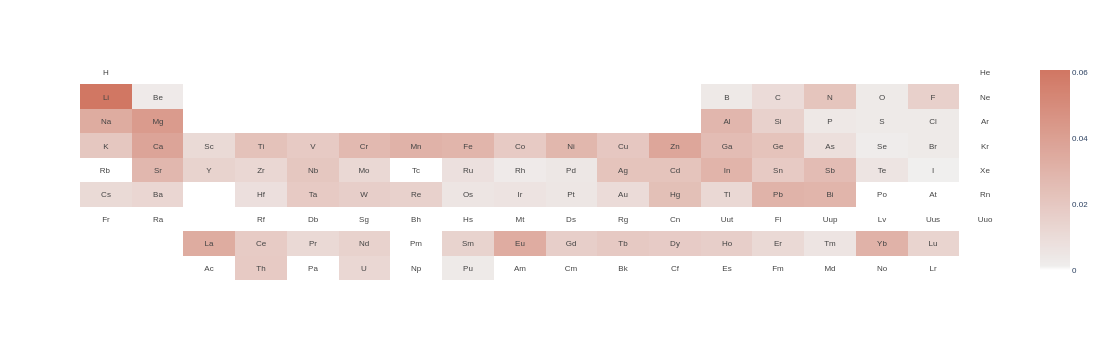

In [81]:
# VP disorder

color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][5])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(209, 119, 99),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=8,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/SV_elements.png",width=15*300, height=10*300, scale=1)

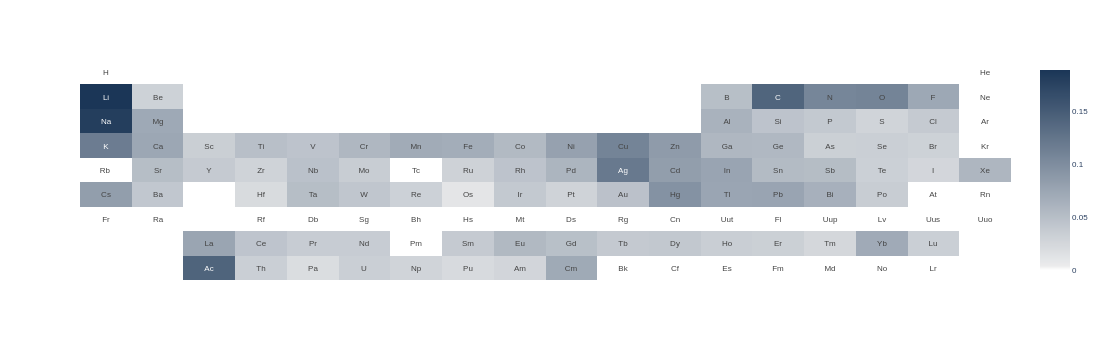

In [82]:
# V+VP disorder

color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][5]+elem_disorder_frac[sym][3])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(27, 54, 87),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=8,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/SV_elements.png",width=15*300, height=10*300, scale=1)

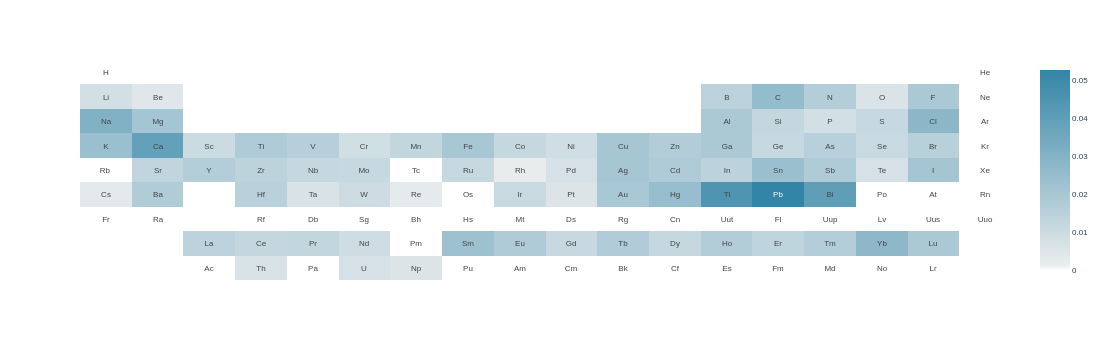

In [83]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][6])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(51, 133, 167),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=8,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
fig.write_image("images/SP_elements.png",width=15*300, height=10*300, scale=1)

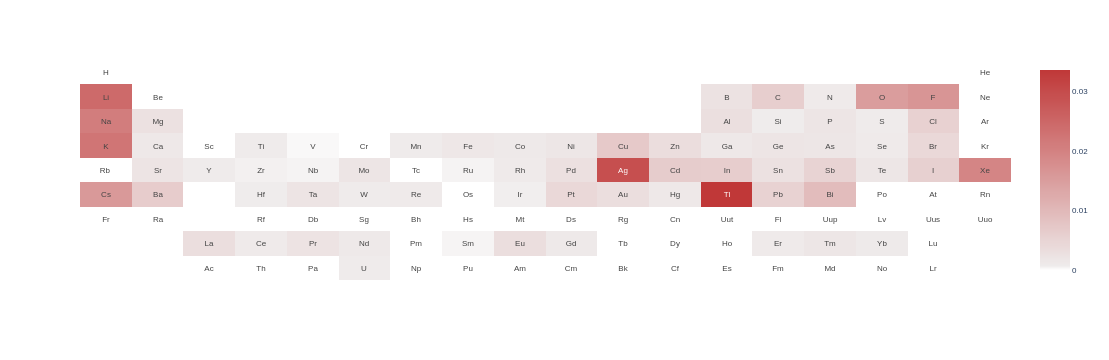

In [84]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][7])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(192, 56, 56),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=8,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/VP_elements.png",width=15*300, height=10*300, scale=1)

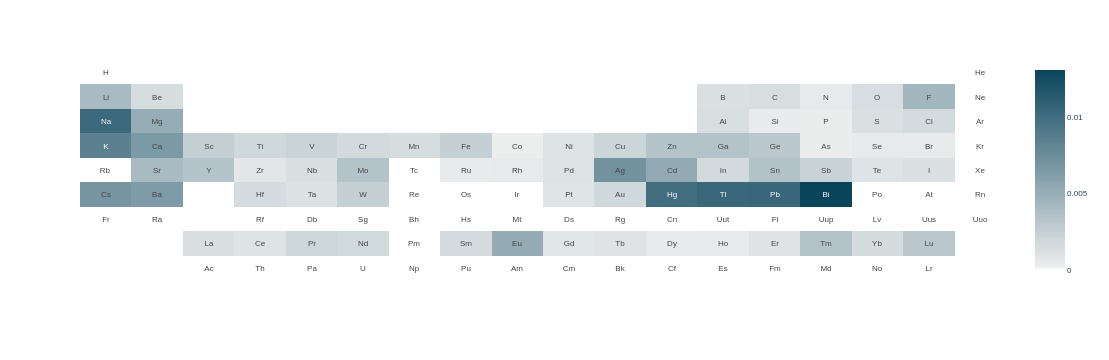

In [85]:
color=[]
for line in symbol:
    line_color=[]
    for sym in line:
        if(sym in elem_disorder_frac.keys()):
            line_color.append(elem_disorder_frac[sym][8])
        else:
            line_color.append(0)
    color.append(line_color)

import plotly.express as px
import numpy as np

fig = px.imshow(color, color_continuous_scale=create_colorscale((240,240,240),(11, 69, 92),50), aspect="auto")
#                title='Fraction of ordered compounds in which element X appears in O orbit')
fig.update_traces(
    text=symbol, texttemplate="%{text}", textfont_size=8,
    customdata=np.moveaxis([element], 0,-1)
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/SVP_elements.png",width=15*300, height=10*300, scale=1)

In [86]:
drank_frac=pd.DataFrame.from_dict(elem_disorder_frac, orient='index', dtype=None, columns=None)
drank_frac1=drank_frac.loc[drank_frac[0]>300]

drankT=pd.DataFrame()
for i in range(0,8):
    drankT[i]=drank_frac1.sort_values(by=i+1, ascending=False).index[:15]

drankT[8]=drank_frac1.sort_values(by=1, ascending=True).index[:15]    
drankT.rename(columns={0:'O',1:'S',2:'V',3:'P',4:'SV',5:'SP',6:'VP',7:'SVP',8:'D'},inplace=True)

drankT.head(15)

O   S   V   P  SV  SP  VP SVP   D
0    B  Mg  Na   F  Li  Pb  Tl  Bi  Mg
1    S  Ti   C  Tl  Mg  Tl  Ag  Pb  Ti
2    P  Cr  Li  Cs  Ca  Bi  Li  Tl  Fe
3    I  Fe   O   O  Zn  Ca   K  Na  Cr
4   Cl  Al  Ag  Rb  Na  Na  Na  Hg  Ca
5    O  Mn   K  Ag  La  Cl   F   K  Zn
6   Tm  Zn  Cu  Cl  Eu  Yb  Rb  Ag  Al
7   Cs  Ca   N   K  Yb   C  Cs  Cs  Mn
8   Rb  Sr  Cs  Pb  Mn  Hg   O  Ca  La
9   Os  La  Hg  Li  Pb   K  Bi  Ba  Bi
10  Se  Zr  Tl   C  In  Sn  Cu  Cd  Sr
11  Te  Co  Rb  Br  Fe  Sm  Cd  Eu  Li
12  Be  Ga  Cd  Na  Bi   I  Ba  Mg  Ga
13  As  Nb   F  Sb  Al  Mg  In   F  Co
14  Br  Ni  Pd   I  Ni  Ag   C  Li  Ag

In [103]:
delem_frac=pd.DataFrame.from_dict(elem_disorder_frac,orient='index', columns=['total','O','S','V','P','SV','SP',"VP",'SVP'])
elements=delem_frac.index.values
delem_frac['element']=elements

In [104]:
delem_frac

total         O         S         V         P        SV        SP  \
Li  6794.0  0.451281  0.300854  0.128349  0.021784  0.060789  0.008390   
Be   676.0  0.772189  0.189349  0.028107  0.001479  0.002959  0.004438   
B   5502.0  0.864958  0.061977  0.046347  0.004544  0.003635  0.014722   
C   4184.0  0.728967  0.074092  0.131453  0.021511  0.010516  0.025813   
N   3918.0  0.708014  0.153905  0.086269  0.011485  0.021950  0.016845   
..     ...       ...       ...       ...       ...       ...       ...   
Pu   315.0  0.733333  0.244444  0.019048  0.000000  0.003175  0.000000   
Am    75.0  0.760000  0.213333  0.026667  0.000000  0.000000  0.000000   
Cm    42.0  0.880952  0.047619  0.071429  0.000000  0.000000  0.000000   
Bk    14.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Cf    16.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          VP       SVP element  
Li  0.024433  0.004121      Li  
Be  0.000000  0.001479      Be  
B   0.002545  0.001272       B  
C   0.006214  0.001434       C  
N   0.001021  0.000510       N  
..       ...       ...     ...  
Pu  0.000000  0.000000      Pu  
Am  0.000000  0.000000      Am  
Cm  0.000000  0.000000      Cm  
Bk  0.000000  0.000000      Bk  
Cf  0.000000  0.000000      Cf  

[96 rows x 10 columns]

In [105]:
dis=[]
for i,x in enumerate(delem_frac['O'].values):
    if(x==0):
        dis.append(0)
    else:
        dis.append(1-delem_frac['O'].values[i])

delem_frac['Disorder']=dis

In [109]:
pt='data/periodic_table.csv'
dpt=pd.read_csv(pt)

In [110]:
dpt=dpt.merge(delem_frac,how='inner',right_on='element',left_on='element')

In [111]:
dpt

element  number  period  group   total         O         S         V  \
0       Li       3       2      1  6794.0  0.451281  0.300854  0.128349   
1       Be       4       2      2   676.0  0.772189  0.189349  0.028107   
2        B       5       2     13  5502.0  0.864958  0.061977  0.046347   
3        C       6       2     14  4184.0  0.728967  0.074092  0.131453   
4        N       7       2     15  3918.0  0.708014  0.153905  0.086269   
..     ...     ...     ...    ...     ...       ...       ...       ...   
91      Pu      94       9      8   315.0  0.733333  0.244444  0.019048   
92      Am      95       9      9    75.0  0.760000  0.213333  0.026667   
93      Cm      96       9     10    42.0  0.880952  0.047619  0.071429   
94      Bk      97       9     11    14.0  1.000000  0.000000  0.000000   
95      Cf      98       9     12    16.0  1.000000  0.000000  0.000000   

           P        SV        SP        VP       SVP  Disorder  
0   0.021784  0.060789  0.008390  0.024433  0.004121  0.548719  
1   0.001479  0.002959  0.004438  0.000000  0.001479  0.227811  
2   0.004544  0.003635  0.014722  0.002545  0.001272  0.135042  
3   0.021511  0.010516  0.025813  0.006214  0.001434  0.271033  
4   0.011485  0.021950  0.016845  0.001021  0.000510  0.291986  
..       ...       ...       ...       ...       ...       ...  
91  0.000000  0.003175  0.000000  0.000000  0.000000  0.266667  
92  0.000000  0.000000  0.000000  0.000000  0.000000  0.240000  
93  0.000000  0.000000  0.000000  0.000000  0.000000  0.119048  
94  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
95  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[96 rows x 14 columns]

In [112]:
colorscale=create_colorscale((255, 255, 255),(255,0,0),50)
fig = px.scatter(dpt, x="group", y="period", text='element', size=8*np.ones(len(dpt)),size_max=20, opacity=0.7, \
                 color='S',color_continuous_scale=create_colorscale((255,255,255),(27,54,87),5))
# fig = px.scatter(dpt, x="group", y="period", text='element', size=15*np.ones(len(dpt)), opacity=0.5, color='S',color_continuous_scale=colorscale)
# fig = px.scatter(dpt, x="group", y="period", 
	        #  size="S",size_max=23,opacity=0.5)

fig.update_layout(
    yaxis = dict(autorange="reversed")
)

# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/S_elements.png",width=15*300, height=10*300, scale=1)

ValueError: 
    Invalid value of type 'builtins.list' received for the 'colorscale' property of make_figure
        Received value: [[0, 'rgb(255,255,255)'], [np.float64(0.25), 'rgb(np.float64(198.0), np.float64(204.75), np.float64(213.0))'], [np.float64(0.5), 'rgb(np.float64(141.0), np.float64(154.5), np.float64(171.0))'], [np.float64(0.75), 'rgb(np.float64(84.0), np.float64(104.25), np.float64(129.0))'], [np.float64(1.0), 'rgb(np.float64(27.0), np.float64(54.0), np.float64(87.0))']]

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


In [113]:
colorscale=create_colorscale((255, 255, 255),(255,0,0),50)
# fig = px.scatter(dpt, x="group", y="period", text='element', size=23*np.ones(len(dpt)), opacity=0.5, color='O',color_continuous_scale=colorscale)
fig = px.scatter(dpt, x="group", y="period", text='element', size=2*np.ones(len(dpt)),size_max=20, opacity=0.5, color='Disorder',color_continuous_scale=colorscale,range_color=(0,1))
# fig = px.scatter(dpt, x="group", y="period", 
# 	         size="S",size_max=23,opacity=0.5)

fig.update_layout(
    yaxis = dict(autorange="reversed")
)
fig.show()

ValueError: 
    Invalid value of type 'builtins.list' received for the 'colorscale' property of make_figure
        Received value: [[0, 'rgb(255,255,255)'], [np.float64(0.02040816326530612), 'rgb(np.float64(255.0), np.float64(249.79591836734693), np.float64(249.79591836734693))'], [np.float64(0.04081632653061224), 'rgb(np.float64(254.99999999999997), np.float64(244.59183673469386), np.float64(244.59183673469386))'], [np.float64(0.061224489795918366), 'rgb(np.float64(255.0), np.float64(239.3877551020408), np.float64(239.3877551020408))'], [np.float64(0.08163265306122448), 'rgb(np.float64(255.0), np.float64(234.18367346938777), np.float64(234.18367346938777))'], [np.float64(0.1020408163265306), 'rgb(np.float64(255.0), np.float64(228.9795918367347), np.float64(228.9795918367347))'], [np.float64(0.12244897959183673), 'rgb(np.float64(255.0), np.float64(223.77551020408163), np.float64(223.77551020408163))'], [np.float64(0.14285714285714285), 'rgb(np.float64(255.0), np.float64(218.57142857142858), np.float64(218.57142857142858))'], [np.float64(0.16326530612244897), 'rgb(np.float64(255.0), np.float64(213.3673469387755), np.float64(213.3673469387755))'], [np.float64(0.18367346938775508), 'rgb(np.float64(255.0), np.float64(208.16326530612244), np.float64(208.16326530612244))'], [np.float64(0.2040816326530612), 'rgb(np.float64(255.0), np.float64(202.9591836734694), np.float64(202.9591836734694))'], [np.float64(0.22448979591836732), 'rgb(np.float64(255.0), np.float64(197.75510204081633), np.float64(197.75510204081633))'], [np.float64(0.24489795918367346), 'rgb(np.float64(255.0), np.float64(192.55102040816325), np.float64(192.55102040816325))'], [np.float64(0.26530612244897955), 'rgb(np.float64(255.0), np.float64(187.3469387755102), np.float64(187.3469387755102))'], [np.float64(0.2857142857142857), 'rgb(np.float64(255.0), np.float64(182.14285714285714), np.float64(182.14285714285714))'], [np.float64(0.3061224489795918), 'rgb(np.float64(255.0), np.float64(176.9387755102041), np.float64(176.9387755102041))'], [np.float64(0.32653061224489793), 'rgb(np.float64(255.00000000000003), np.float64(171.73469387755105), np.float64(171.73469387755105))'], [np.float64(0.3469387755102041), 'rgb(np.float64(255.0), np.float64(166.53061224489798), np.float64(166.53061224489798))'], [np.float64(0.36734693877551017), 'rgb(np.float64(255.0), np.float64(161.3265306122449), np.float64(161.3265306122449))'], [np.float64(0.3877551020408163), 'rgb(np.float64(255.0), np.float64(156.12244897959184), np.float64(156.12244897959184))'], [np.float64(0.4081632653061224), 'rgb(np.float64(254.99999999999997), np.float64(150.91836734693877), np.float64(150.91836734693877))'], [np.float64(0.42857142857142855), 'rgb(np.float64(254.99999999999997), np.float64(145.7142857142857), np.float64(145.7142857142857))'], [np.float64(0.44897959183673464), 'rgb(np.float64(255.0), np.float64(140.51020408163268), np.float64(140.51020408163268))'], [np.float64(0.4693877551020408), 'rgb(np.float64(255.0), np.float64(135.3061224489796), np.float64(135.3061224489796))'], [np.float64(0.4897959183673469), 'rgb(np.float64(255.0), np.float64(130.10204081632654), np.float64(130.10204081632654))'], [np.float64(0.5102040816326531), 'rgb(np.float64(255.0), np.float64(124.89795918367346), np.float64(124.89795918367346))'], [np.float64(0.5306122448979591), 'rgb(np.float64(255.0), np.float64(119.69387755102042), np.float64(119.69387755102042))'], [np.float64(0.5510204081632653), 'rgb(np.float64(255.0), np.float64(114.48979591836736), np.float64(114.48979591836736))'], [np.float64(0.5714285714285714), 'rgb(np.float64(255.0), np.float64(109.28571428571429), np.float64(109.28571428571429))'], [np.float64(0.5918367346938775), 'rgb(np.float64(255.0), np.float64(104.08163265306122), np.float64(104.08163265306122))'], [np.float64(0.6122448979591836), 'rgb(np.float64(255.0), np.float64(98.87755102040819), np.float64(98.87755102040819))'], [np.float64(0.6326530612244897), 'rgb(np.float64(255.0), np.float64(93.67346938775512), np.float64(93.67346938775512))'], [np.float64(0.6530612244897959), 'rgb(np.float64(255.0), np.float64(88.46938775510205), np.float64(88.46938775510205))'], [np.float64(0.673469387755102), 'rgb(np.float64(255.0), np.float64(83.26530612244899), np.float64(83.26530612244899))'], [np.float64(0.6938775510204082), 'rgb(np.float64(255.0), np.float64(78.06122448979592), np.float64(78.06122448979592))'], [np.float64(0.7142857142857142), 'rgb(np.float64(255.0), np.float64(72.85714285714288), np.float64(72.85714285714288))'], [np.float64(0.7346938775510203), 'rgb(np.float64(255.0), np.float64(67.65306122448982), np.float64(67.65306122448982))'], [np.float64(0.7551020408163265), 'rgb(np.float64(255.0), np.float64(62.448979591836746), np.float64(62.448979591836746))'], [np.float64(0.7755102040816326), 'rgb(np.float64(255.0), np.float64(57.24489795918368), np.float64(57.24489795918368))'], [np.float64(0.7959183673469387), 'rgb(np.float64(255.0), np.float64(52.04081632653064), np.float64(52.04081632653064))'], [np.float64(0.8163265306122448), 'rgb(np.float64(255.0), np.float64(46.836734693877574), np.float64(46.836734693877574))'], [np.float64(0.836734693877551), 'rgb(np.float64(255.0), np.float64(41.63265306122451), np.float64(41.63265306122451))'], [np.float64(0.8571428571428571), 'rgb(np.float64(255.0), np.float64(36.42857142857144), np.float64(36.42857142857144))'], [np.float64(0.8775510204081632), 'rgb(np.float64(255.0), np.float64(31.224489795918373), np.float64(31.224489795918373))'], [np.float64(0.8979591836734693), 'rgb(np.float64(255.0), np.float64(26.020408163265333), np.float64(26.020408163265333))'], [np.float64(0.9183673469387754), 'rgb(np.float64(255.0), np.float64(20.81632653061227), np.float64(20.81632653061227))'], [np.float64(0.9387755102040816), 'rgb(np.float64(255.0), np.float64(15.6122448979592), np.float64(15.6122448979592))'], [np.float64(0.9591836734693877), 'rgb(np.float64(255.0), np.float64(10.408163265306134), np.float64(10.408163265306134))'], [np.float64(0.9795918367346939), 'rgb(np.float64(255.0), np.float64(5.204081632653067), np.float64(5.204081632653067))'], [np.float64(1.0), 'rgb(np.float64(255.0), np.float64(0.0), np.float64(0.0))']]

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


## Distribution of disorder for alkali metals

alkali_me=['Li','Na','K','Rb','Cs']

In [114]:
alkali_me=['Li','Na','K','Rb','Cs']

In [115]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    for orb in elem_orb:
        for el in orb:
            if(el in alkali_me):
                switch=1
    if(switch==1):
        ind.append(i)

In [116]:
alkali=dbmax_struct.iloc[ind]
len(alkali)

20712

In [117]:
elem_disorder, elem_disorder_frac=calculate_elements(alkali_me,alkali)

In [118]:
def plot_elements_1bar(elem_disorder, filename, frac=True,barWidth=1,figsize=(15,5),xfontsize=9,yfontsize=10): 
    bars, total, names, r, bottom3 = bars_fill(elem_disorder,frac)
    
    if(frac==True):
        caption='fraction of ordered/disordered compounds'
    else:
        caption='number of ordered/disordered compounds'
    
    plt.figure(figsize=figsize)

    # Create brown bars
    plt.bar(r, bars[0,:], color='blue', edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    plt.bar(r, bars[1,:], bottom=bars[0,:], color='orange', edgecolor='white', width=barWidth,label='S')
    plt.bar(r, bars[2,:], bottom=bottom3[0,:], color='red', edgecolor='white', width=barWidth,label='V')
    plt.bar(r, bars[3,:], bottom=bottom3[1,:], color='green', edgecolor='white', width=barWidth,label='P')
    plt.bar(r, bars[4,:], bottom=bottom3[2,:], color='magenta', edgecolor='white', width=barWidth,label='SV')
    plt.bar(r, bars[5,:], bottom=bottom3[3,:], color='cyan', edgecolor='white', width=barWidth,label='SP') 
    plt.bar(r, bars[6,:], bottom=bottom3[4,:], color='purple', edgecolor='white', width=barWidth,label='VP')
    plt.bar(r, bars[7,:], bottom=bottom3[5,:], color='black', edgecolor='white', width=barWidth,label='SVP')

    # Custom X axis
    plt.xticks(r, names, fontweight='bold',fontsize=xfontsize)
    # plt.xlabel("element",fontweight='bold',fontsize=12)
    plt.ylabel(caption,fontweight='bold',fontsize=yfontsize)
    plt.ylim(0,1)
    plt.legend()
    path='/Users/elenapatyukova/Documents/Disorder-prediction/figures/'
    plt.savefig(path+filename, transparent=None, dpi=400, format='png')

    # Show graphic
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/elenapatyukova/Documents/Disorder-prediction/figures/alkali.png'

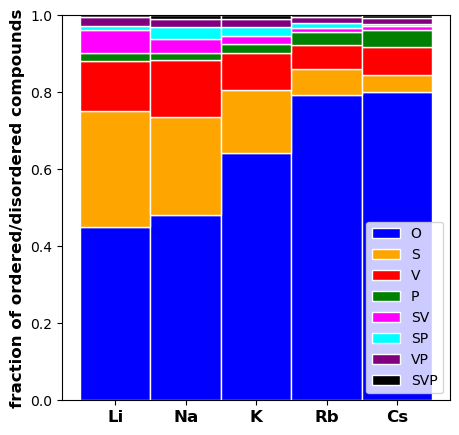

In [119]:
plot_elements_1bar(elem_disorder_frac, filename='alkali.png', frac=True,barWidth=1,figsize=(5,5),xfontsize=12,yfontsize=12)

## Distribution of disorder for Alkaline Earth Metals

In [120]:
alkaline_earth_me=['Be','Mg','Ca','Sr','Ba']

In [121]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    for orb in elem_orb:
        for el in orb:
            if(el in alkaline_earth_me):
                switch=1
    if(switch==1):
        ind.append(i)

In [122]:
alkaline=dbmax_struct.iloc[ind]
len(alkaline)

26857

In [123]:
elem_disorder, elem_disorder_frac=calculate_elements(alkaline_earth_me,alkaline)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/elenapatyukova/Documents/Disorder-prediction/figures/alkaline_earth.png'

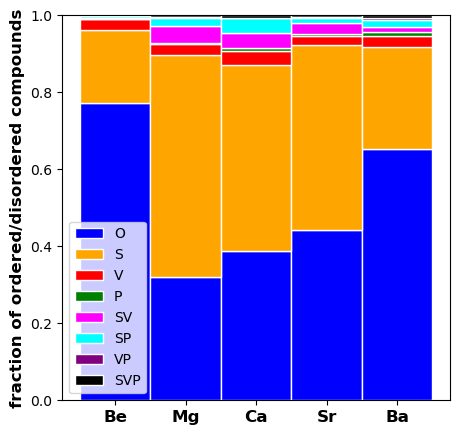

In [124]:
plot_elements_1bar(elem_disorder_frac, filename='alkaline_earth.png', frac=True,barWidth=1,figsize=(5,5),xfontsize=12,yfontsize=12)

# Distribution over structures

### Distribution over space groups

In [155]:
dbmax_struct.columns

Index(['formula', 'ICSD_ID', 'group_num', 'Z', 'label', 'species',
       'multiplicity', 'Wyckoff_symbol', 'occupancy', 'internal_intersection',
       'internal_intersect_index', 'vacancy_number', 'external_intersection',
       'intersecting_orbits', 'intersect_orbit_connected',
       'intersect_orbit_connected_mult', 'intersect_orbit_connected_occ',
       'orbit_disorder', 'mixing_entropy', 'conf_entropy', 'Unnamed: 0',
       'DB_id', 'Col_code', 'name', 'StructureType', 'Temperature', 'Pressure',
       'CellVolume', 'FormulaUnitsPerCell', 'MineralName', 'MineralGroup',
       'PearsonSymbol', 'ANXFormula', 'ABFormula', 'disorder_set', 'num_el',
       'num_orb', 'ordered_formula', 'normalised_composition',
       'orbit_elements_comp'],
      dtype='object')

In [156]:
element_disorder=dbmax_struct[['ICSD_ID','formula','disorder_set','orbit_disorder','orbit_elements_comp','group_num']]

In [161]:
mapping_groups_sys={}
mapping_groups_sys['triclinic']=[1,2]
mapping_groups_sys['monoclinic']=list(np.linspace(3,15,13,dtype=int))
mapping_groups_sys['orthorhombic']=list(np.linspace(16,74,59,dtype=int))
mapping_groups_sys['tetragonal']=list(np.linspace(75,142,68,dtype=int))
mapping_groups_sys['trigonal']=list(np.linspace(143,167,25,dtype=int))
mapping_groups_sys['hexagonal']=list(np.linspace(168,194,27,dtype=int))
mapping_groups_sys['cubic']=list(np.linspace(195,230,36,dtype=int))

mapping_groups={}
mapping_groups['1']=[1]
mapping_groups['-1']=[2]
mapping_groups['2']=[3,4,5]
mapping_groups['m']=[6,7,8,9]
mapping_groups['2/m']=[10,11,12,13,14,15]
mapping_groups['222']=[16,17,18,19,20,21,22,23,24]
mapping_groups['mm2']=[25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46]
mapping_groups['2/m 2/m 2/m']=list(np.linspace(47,74,28,dtype=int))
mapping_groups['4']=list(np.linspace(75,80,6,dtype=int))
mapping_groups['-4']=list(np.linspace(81,82,2,dtype=int))
mapping_groups['4/m']=list(np.linspace(83,88,6,dtype=int))
mapping_groups['422']=list(np.linspace(89,98,10,dtype=int))
mapping_groups['4mm']=list(np.linspace(99,110,12,dtype=int))
mapping_groups['-42m']=list(np.linspace(111,122,12,dtype=int))
mapping_groups['4/m 2/m 2/m']=list(np.linspace(123,142,20,dtype=int))
mapping_groups['3']=list(np.linspace(143,146,4,dtype=int))
mapping_groups['-3']=list(np.linspace(147,148,2,dtype=int))
mapping_groups['32']=list(np.linspace(149,155,7,dtype=int))
mapping_groups['3m']=list(np.linspace(156,161,6,dtype=int))
mapping_groups['3 2/m']=list(np.linspace(162,167,6,dtype=int))
mapping_groups['6']=list(np.linspace(168,173,6,dtype=int))
mapping_groups['-6']=[174]
mapping_groups['6/m']=[175,176]
mapping_groups['622']=list(np.linspace(177,182,6,dtype=int))
mapping_groups['6mm']=list(np.linspace(183,186,4,dtype=int))
mapping_groups['-6m2']=list(np.linspace(187,190,4,dtype=int))
mapping_groups['6/m 2/m 2/m']=list(np.linspace(191,194,4,dtype=int))
mapping_groups['23']=list(np.linspace(195,199,5,dtype=int))
mapping_groups['2/m -3']=list(np.linspace(200,206,7,dtype=int))
mapping_groups['432']=list(np.linspace(207,214,8,dtype=int))
mapping_groups['-43m']=list(np.linspace(215,220,6,dtype=int))
mapping_groups['4/m -3 2/m']=list(np.linspace(221,230,10,dtype=int))

In [185]:
crystal_sys=[]
for i in range(len(element_disorder)):
    num=element_disorder.iloc[i]['group_num']
    for key,value in mapping_groups_sys.items():
        if(num in value):
            crystal_sys.append(key)

point_groups=[]
for i in range(len(element_disorder)):
    num=element_disorder.iloc[i]['group_num']
    for key,value in mapping_groups.items():
        if(num in value):
            point_groups.append(key)

olist=[{'O'}]
slist=[{'S'},{'O','S'}]
plist=[{'P'},{'O','P'}]
vlist=[{'V'},{'O','V'}]
            
dis_class=[]
for i in range(len(element_disorder)):
    dis=element_disorder.iloc[i]['disorder_set']
    if(dis in olist):
        dis_class.append('O')
    elif(dis in slist):
        dis_class.append('S')
    elif(dis in vlist):
        dis_class.append('V')
    elif(dis in plist):
        dis_class.append('P')
    else:
        dis_class.append('M')

element_disorder['crystal_system']=crystal_sys
element_disorder['point_groups']=point_groups
element_disorder['disorder_class']=dis_class

In [186]:
space_groups=np.linspace(1,230,230,dtype=int)

In [187]:
def calculate_for_space_groups(element_disorder,space_groups):
    group_disorder={}
    for key in space_groups:
        group_disorder[key]=np.zeros(5)

    for i in range(len(element_disorder)):
        dis_class=element_disorder['disorder_class'].values[i]
        group=element_disorder['group_num'].values[i]
        
        if(dis_class=='O'):
            group_disorder[group][0]+=1
        elif(dis_class=='S'):
            group_disorder[group][1]+=1
        elif(dis_class=='V'):
            group_disorder[group][2]+=1
        elif(dis_class=='P'):
            group_disorder[group][3]+=1
        elif(dis_class=='M'):
            group_disorder[group][4]+=1

    group_disorder_frac={}
    total_values=[]
    frac_values=[]
    for key in group_disorder.keys():
        group_disorder_frac[key]=np.zeros(6)
        group_disorder_frac[key][0]=np.sum(group_disorder[key])
        total_values.append(group_disorder_frac[key][0])
        if(group_disorder_frac[key][0]!=0):
            for i in range(1,6):
                group_disorder_frac[key][i]=round(group_disorder[key][i-1]/group_disorder_frac[key][0],2)
        else:
            for i in range(1,6):
                group_disorder_frac[key][i]=0
        frac_values.append(group_disorder_frac[key][1:9])

    return group_disorder, group_disorder_frac

In [188]:
group_disorder, group_disorder_frac=calculate_for_space_groups(element_disorder,space_groups)

In [189]:
def plot_groups(group_disorder_frac, title, filename, frac=True,barWidth=1,names=None,x_caption=None,figsize=(15,7)): 
    bars, total, names_simple, r, bottom3 = bars_fill(group_disorder_frac,frac)
    
    if(frac==True):
        caption='fraction of ordered/disordered compounds'
    else:
        caption='number of ordered/disordered compounds'
    
    plt.figure(figsize=figsize)
    ax1=plt.subplot(111)
    ax2=ax1.twiny()
    # Create brown bars

    ax1.bar(names_simple, bars[0,:], color='blue', edgecolor='white', width=barWidth,label='O')
    # Create green bars (middle), on top of the first ones
    ax1.bar(names_simple, bars[1,:], bottom=bars[0,:], color='orange', edgecolor='white', width=barWidth,label='S')
    ax1.bar(names_simple, bars[2,:], bottom=bottom3[0,:], color='red', edgecolor='white', width=barWidth,label='V')
    ax1.bar(names_simple, bars[3,:], bottom=bottom3[1,:], color='green', edgecolor='white', width=barWidth,label='P')
    ax1.bar(names_simple, bars[4,:], bottom=bottom3[2,:], color='magenta', edgecolor='white', width=barWidth,label='SV')
    ax1.bar(names_simple, bars[5,:], bottom=bottom3[3,:], color='cyan', edgecolor='white', width=barWidth,label='SP') 
    ax1.bar(names_simple, bars[6,:], bottom=bottom3[4,:], color='purple', edgecolor='white', width=barWidth,label='VP')
    ax1.bar(names_simple, bars[7,:], bottom=bottom3[5,:], color='black', edgecolor='white', width=barWidth,label='SVP')

    # Custom X axis
    if(names!=None):
        ax1.set_xticks(range(len(names)), names, rotation='vertical',fontsize=9,fontweight='bold')
    if(x_caption!=None):
        ax1.set_xlabel(x_caption,fontweight='bold',fontsize=12)
    ax1.set_ylabel(caption,fontweight='bold',fontsize=12)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(names_simple)
    ax2.set_xticklabels(total,rotation='vertical')
    ax1.legend()
    ax1.set_title(title,fontweight='bold',fontsize=12)
    path='/Users/elenapatyukova/Documents/Disorder-prediction/figures/'
    plt.savefig(path+filename, transparent=None, dpi=400, format='png',bbox_inches='tight')
    plt.grid(visible=False)
    
    plt.show()

In [190]:
df=pd.DataFrame.from_dict(group_disorder_frac,orient='index',columns=['total','O','S','V','P','M'])

In [191]:
df.reset_index(drop=True,inplace=True)
df['space_group']=np.linspace(1,230,230,dtype=int)


In [192]:
nm={}
for x,key in enumerate(mapping_groups_sys.keys()):
    nm[key]=x

nm1={}
for x,key in enumerate(mapping_groups.keys()):
    nm1[key]=x

In [193]:
crystal_system=[]
point_groups=[]
for num in space_groups:
    for key, value in mapping_groups_sys.items():
        if(num in value):
            crystal_system.append(key)
    for key, value in mapping_groups.items():
        if(num in value):
            point_groups.append(key)

In [194]:
df['D']=np.ones(len(df))-df['O'].values

In [195]:
df['crystal_system']=crystal_system
df['crystal_class']=point_groups

In [196]:
df['weights']=df['total'].values+np.ones(len(df))*0.01

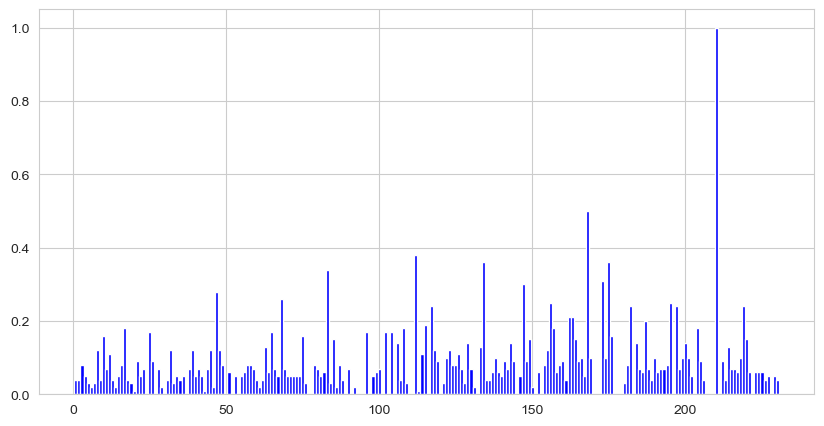

In [197]:
plt.figure(figsize=(10,5))
plt.bar(df['space_group'].values,df['V'].values,color='blue', edgecolor='white', width=1,label='O')
plt.show()

In [198]:

df

total     O     S     V     P     M  space_group     D crystal_system  \
0     209.0  0.62  0.19  0.04  0.01  0.14            1  0.38      triclinic   
1    2245.0  0.69  0.16  0.04  0.02  0.09            2  0.31      triclinic   
2      26.0  0.50  0.27  0.08  0.00  0.15            3  0.50     monoclinic   
3     394.0  0.76  0.12  0.05  0.01  0.06            4  0.24     monoclinic   
4     254.0  0.61  0.20  0.03  0.02  0.14            5  0.39     monoclinic   
..      ...   ...   ...   ...   ...   ...          ...   ...            ...   
225   167.0  0.29  0.56  0.04  0.00  0.11          226  0.71          cubic   
226  5330.0  0.14  0.62  0.05  0.00  0.19          227  0.86          cubic   
227     3.0  0.00  0.33  0.00  0.00  0.67          228  1.00          cubic   
228   747.0  0.22  0.66  0.05  0.01  0.07          229  0.78          cubic   
229   664.0  0.15  0.54  0.04  0.00  0.28          230  0.85          cubic   

    crystal_class  weights  
0               1   209.01  
1              -1  2245.01  
2               2    26.01  
3               2   394.01  
4               2   254.01  
..            ...      ...  
225    4/m -3 2/m   167.01  
226    4/m -3 2/m  5330.01  
227    4/m -3 2/m     3.01  
228    4/m -3 2/m   747.01  
229    4/m -3 2/m   664.01  

[230 rows x 11 columns]

In [199]:
df1=df.copy()

In [200]:
new_s=[]

for s in df['S'].values:
    if(s<np.mean(df['S'])+2*np.std(df['S'])):
        new_s.append(s)
    else:
        new_s.append(np.mean(df['S'])+2*np.std(df['S']))

new_p=[]

for s in df['P'].values:
    if(s<np.mean(df['P'])+2*np.std(df['P'])):
        new_p.append(s)
    else:
        new_p.append(np.mean(df['P'])+2*np.std(df['P']))

new_v=[]

for s in df['V'].values:
    if(s<np.mean(df['V'])+2*np.std(df['V'])):
        new_v.append(s)
    else:
        new_v.append(np.mean(df['V'])+2*np.std(df['V']))
        
new_m=[]

for s in df['M'].values:
    if(s<np.mean(df['M'])+2*np.std(df['M'])):
        new_m.append(s)
    else:
        new_m.append(np.mean(df['M'])+2*np.std(df['M']))

In [201]:
df1['S']=new_s
df1['P']=new_p
df1['V']=new_v
df1['M']=new_m

In [202]:
df1

total     O         S     V     P         M  space_group     D  \
0     209.0  0.62  0.190000  0.04  0.01  0.140000            1  0.38   
1    2245.0  0.69  0.160000  0.04  0.02  0.090000            2  0.31   
2      26.0  0.50  0.270000  0.08  0.00  0.150000            3  0.50   
3     394.0  0.76  0.120000  0.05  0.01  0.060000            4  0.24   
4     254.0  0.61  0.200000  0.03  0.02  0.140000            5  0.39   
..      ...   ...       ...   ...   ...       ...          ...   ...   
225   167.0  0.29  0.560000  0.04  0.00  0.110000          226  0.71   
226  5330.0  0.14  0.576713  0.05  0.00  0.190000          227  0.86   
227     3.0  0.00  0.330000  0.00  0.00  0.467995          228  1.00   
228   747.0  0.22  0.576713  0.05  0.01  0.070000          229  0.78   
229   664.0  0.15  0.540000  0.04  0.00  0.280000          230  0.85   

    crystal_system crystal_class  weights  
0        triclinic             1   209.01  
1        triclinic            -1  2245.01  
2       monoclinic             2    26.01  
3       monoclinic             2   394.01  
4       monoclinic             2   254.01  
..             ...           ...      ...  
225          cubic    4/m -3 2/m   167.01  
226          cubic    4/m -3 2/m  5330.01  
227          cubic    4/m -3 2/m     3.01  
228          cubic    4/m -3 2/m   747.01  
229          cubic    4/m -3 2/m   664.01  

[230 rows x 11 columns]

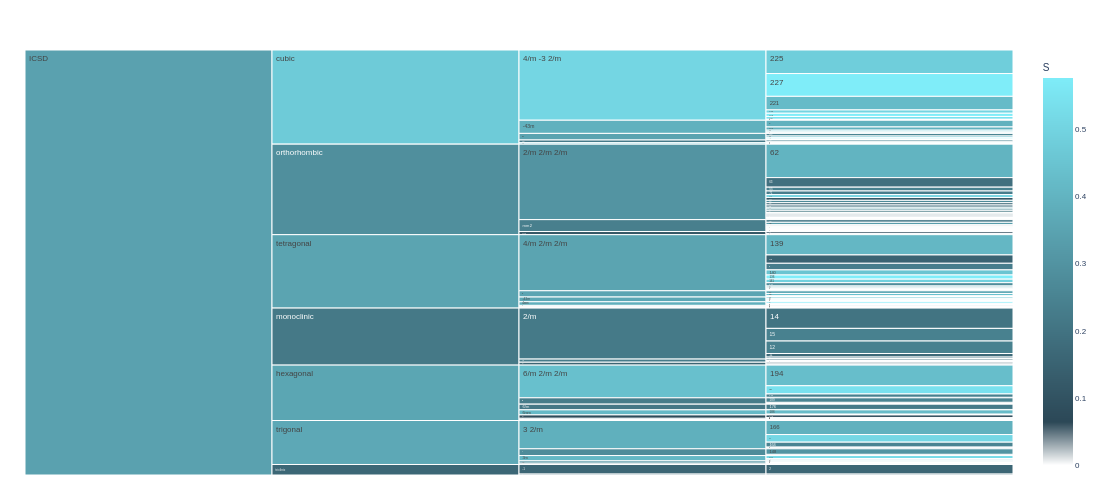

In [207]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='S',
                  color_continuous_scale=create_colorscale((34,51, 67),(127, 237, 249),10),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()

fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/S_structures.png",width=5*300, height=8*300, scale=1)
# 'RdBu'

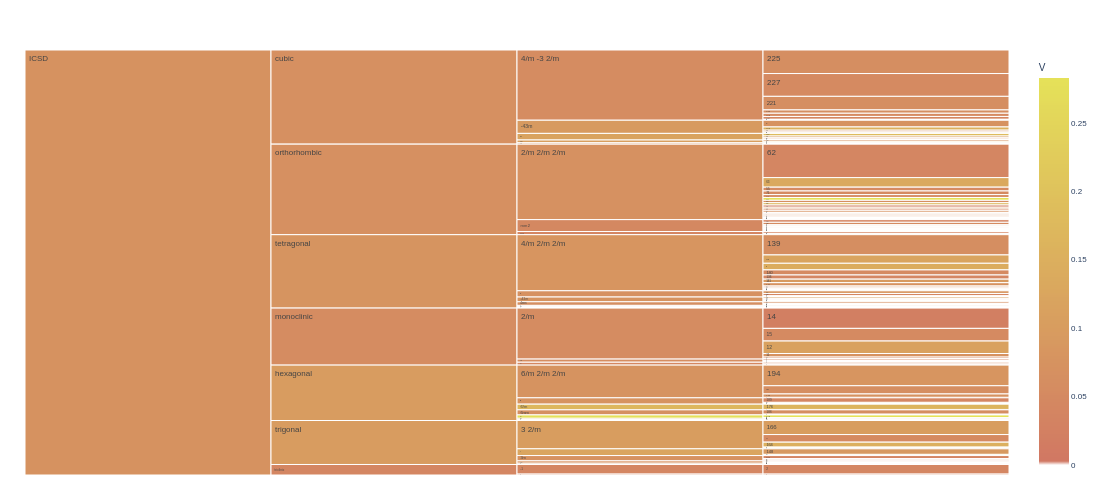

In [208]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='V',
                  color_continuous_scale=create_colorscale((209, 119, 99),(229, 226, 89),100),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()

fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/V_structures.png",width=5*300, height=8*300, scale=1)
# 'RdBu'

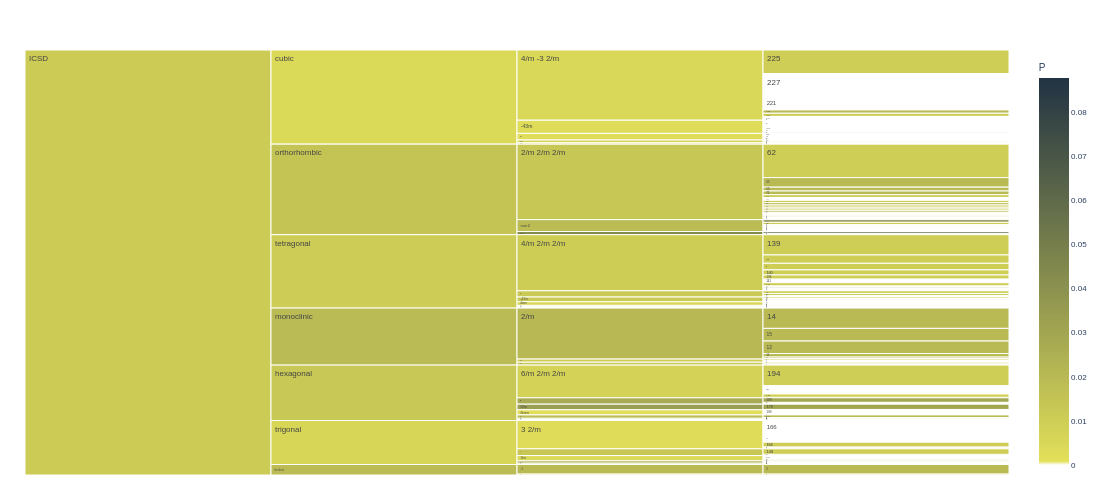

In [209]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='P',
                  color_continuous_scale=create_colorscale((229,226,89),(34,51,67),100),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
# fig.write_image("images/P_structures.png",width=5*300, height=8*300, scale=1)

In [125]:
fig = px.icicle(df1, path=[px.Constant("ICSD"),'crystal_system', 'crystal_class', 'space_group'], values='weights',
                  color='M',
                  color_continuous_scale=create_colorscale((242, 80, 65),(34,51,67),100),width=500, height=500)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces()
fig.update_coloraxes(showscale=True)
fig.update_layout(font=dict(size=8))
fig.show()
fig.write_image("images/M_structures.png",width=5*300, height=8*300, scale=1)

NameError: name 'df1' is not defined

# Oxides

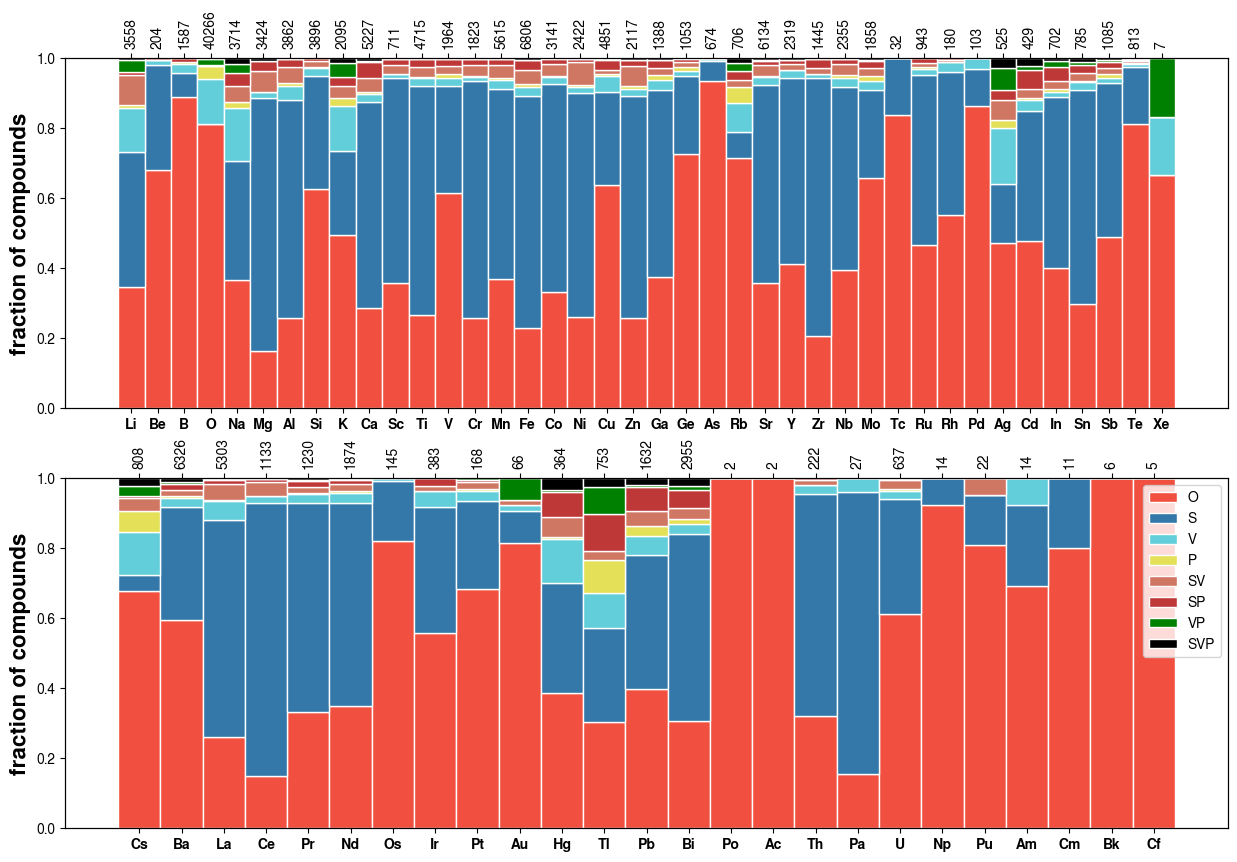

In [166]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='O'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='C'or el=='Cl'or el=='F'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'O', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/oxides.png',n=40,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

# Fluorides

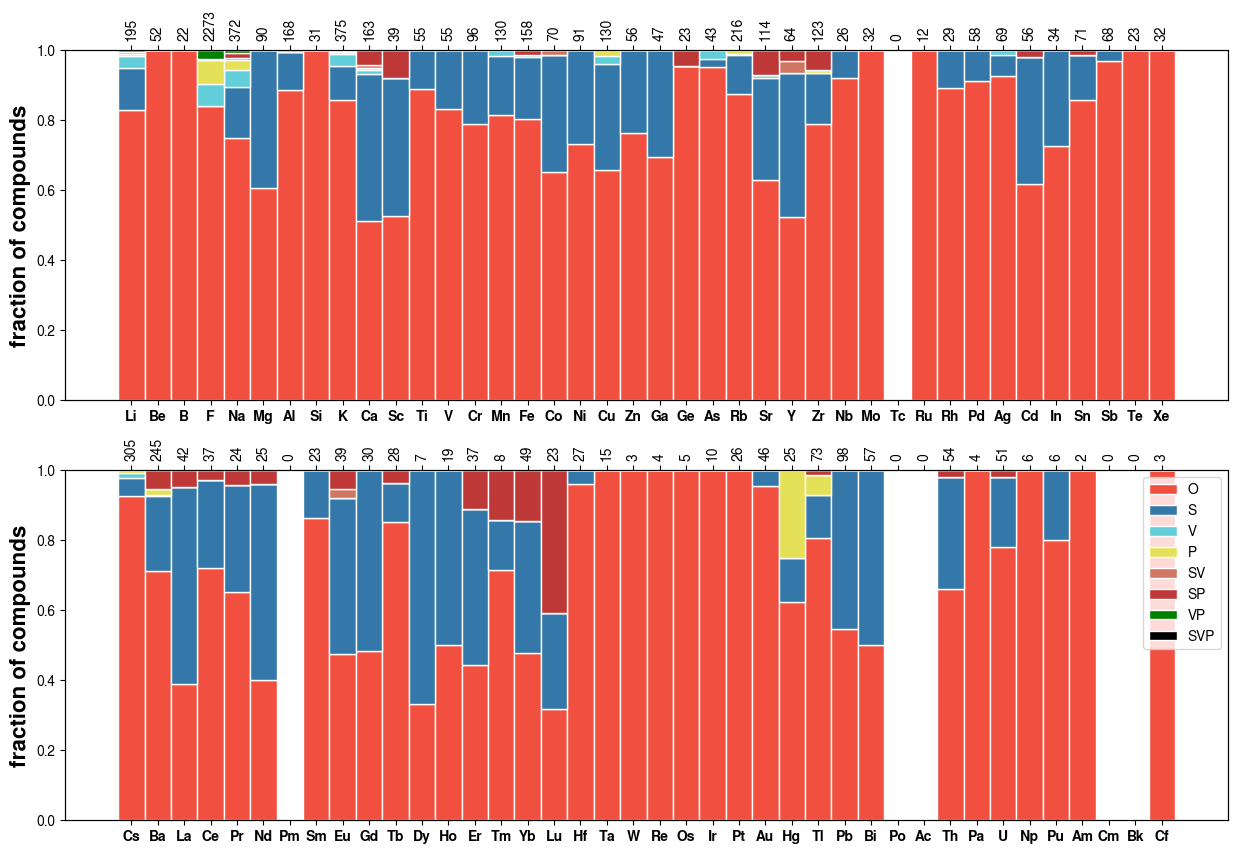

In [164]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='F'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='C'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'F', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/fluorides.png',n=40,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

# Sulfides

In [167]:
len(oxides)

35098

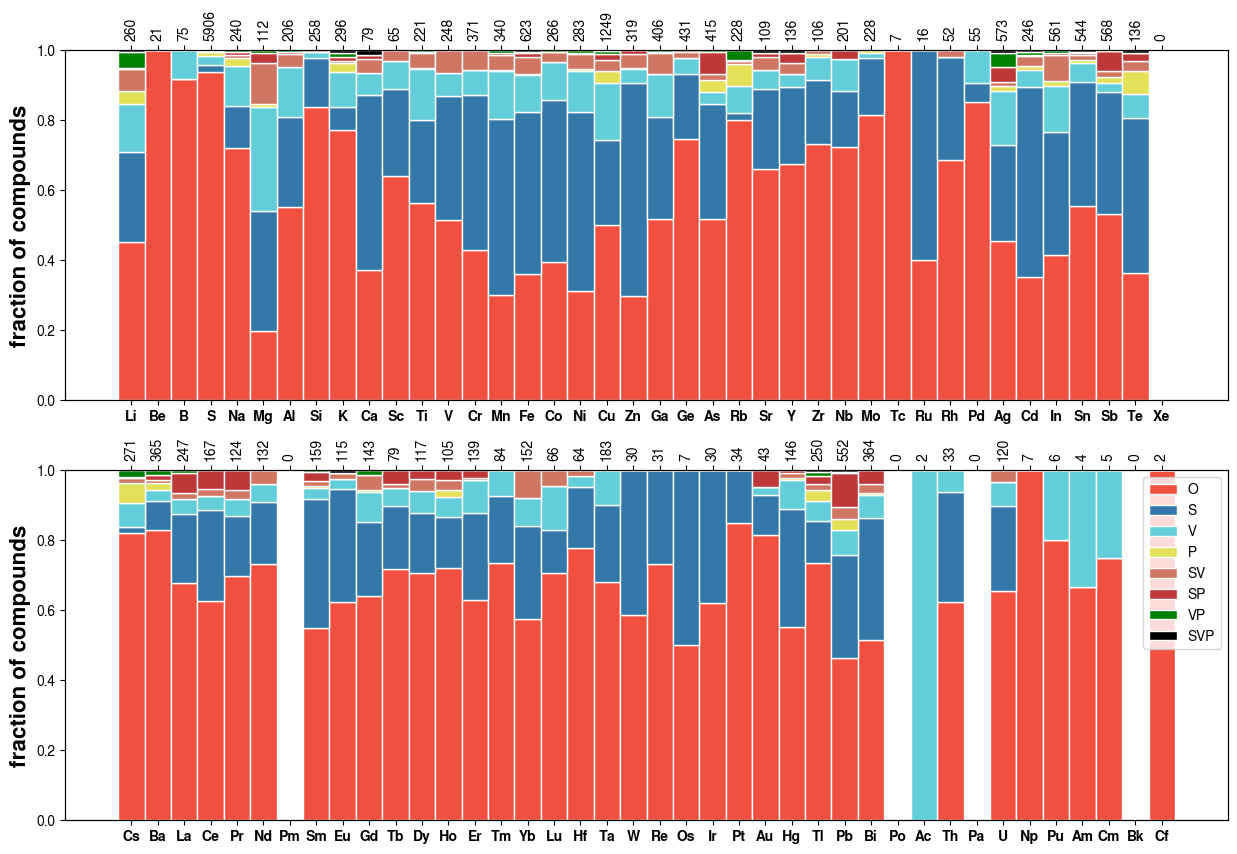

In [134]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='S'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='F'or el=='N'or el=='C'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'S', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/sulfides.png',n=40,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

# Iodides

In [136]:
len(oxides)

5728

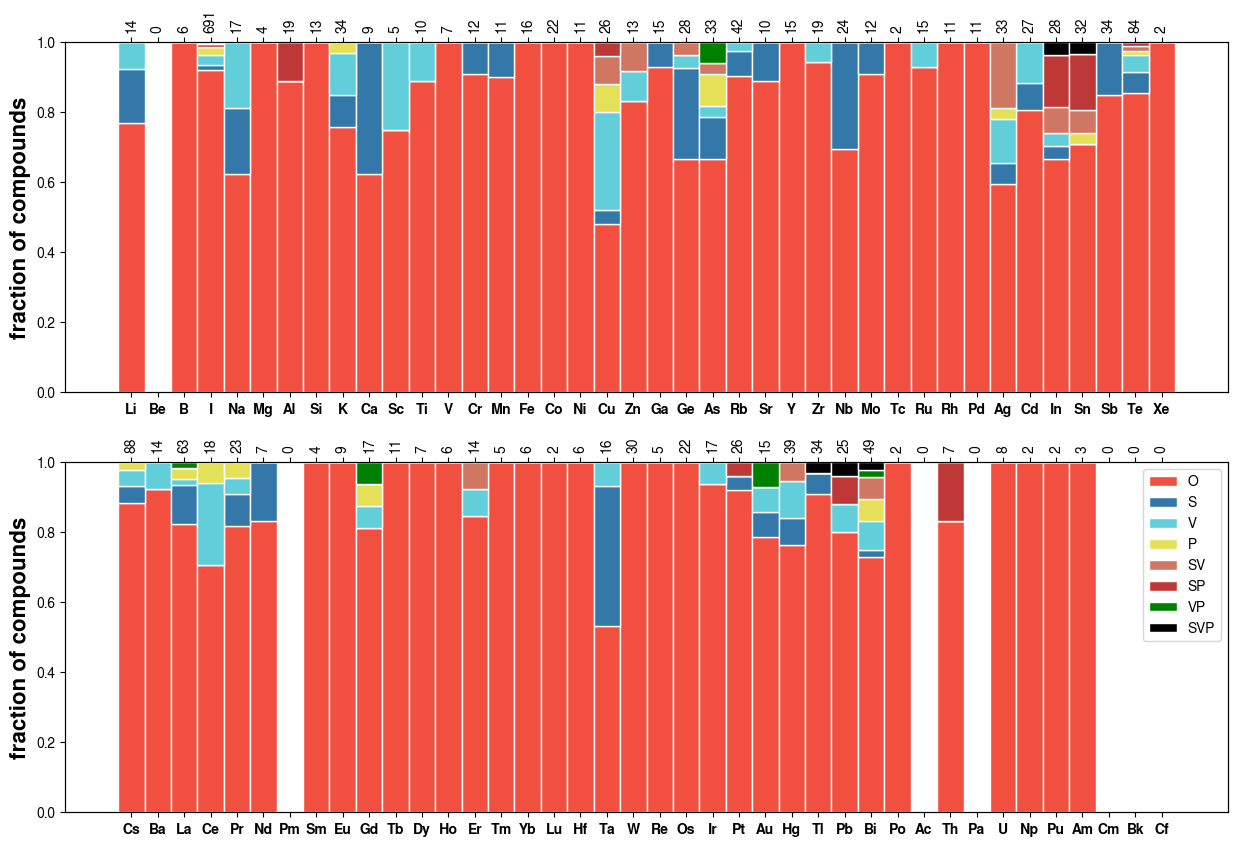

In [93]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='I'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='C'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/iodides.png',n=40,frac=True,barWidth=1)



# Carbides

In [95]:
len(oxides)

658

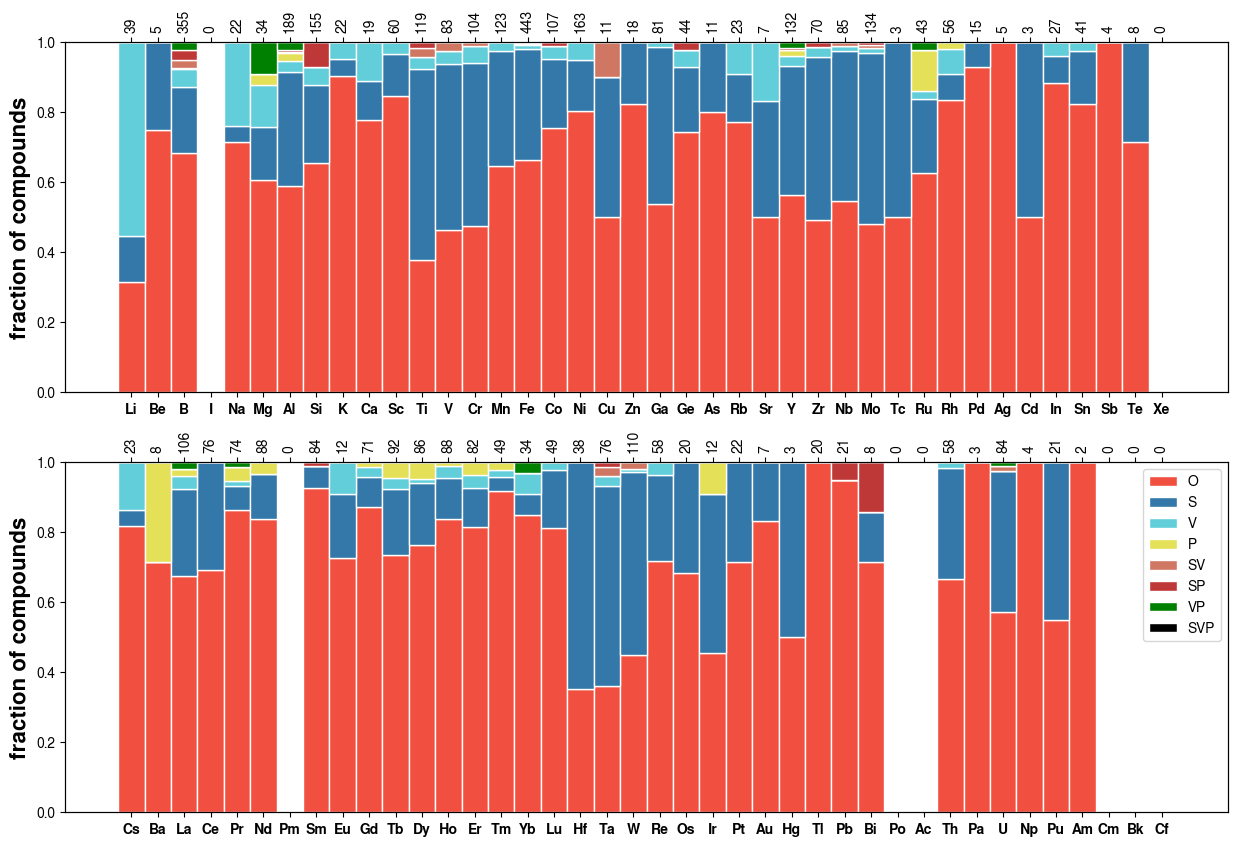

In [101]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='C'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/carbides.png',n=40,frac=True,barWidth=1)


# Nitrides

In [102]:
len(oxides)

1978

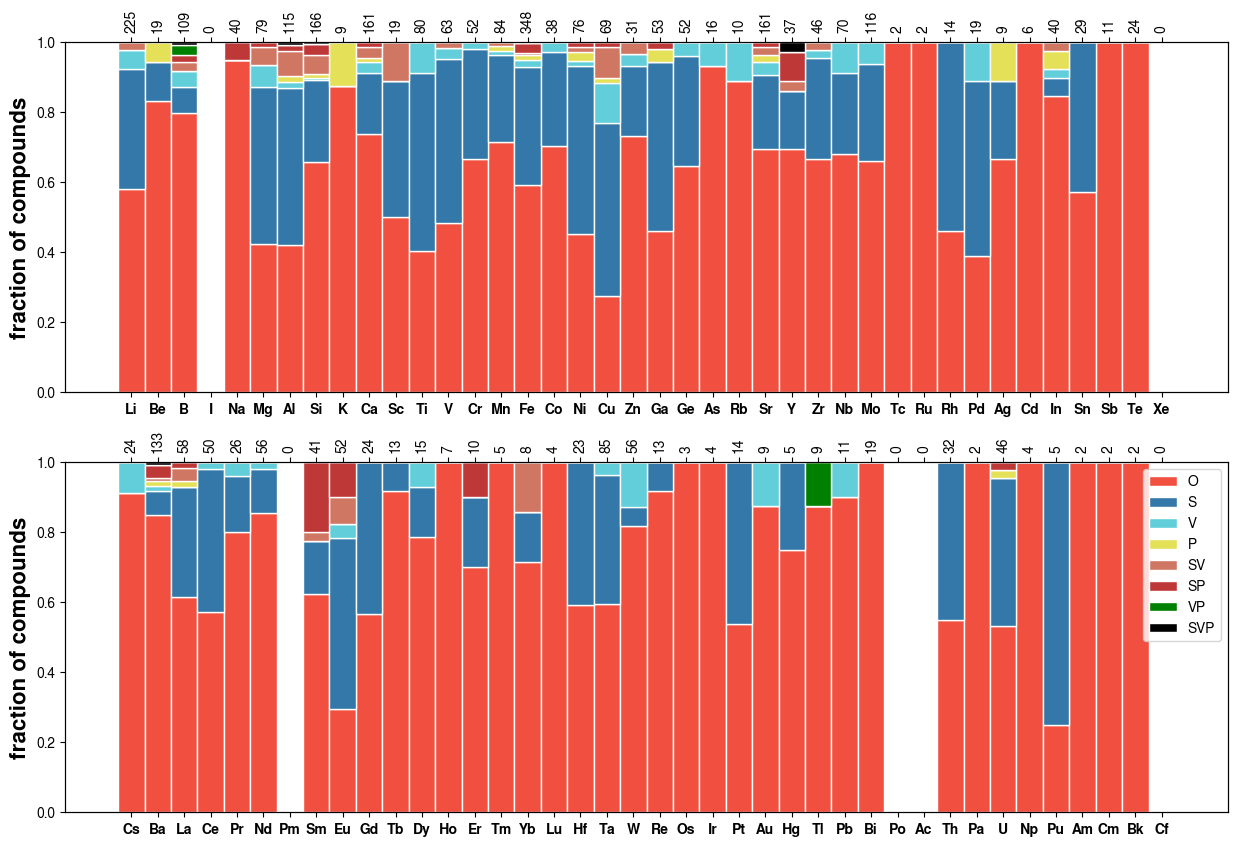

In [97]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='N'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='C'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/nitrides.png',n=40,frac=True,barWidth=1)

# Phosphides

In [98]:
len(oxides)

1485

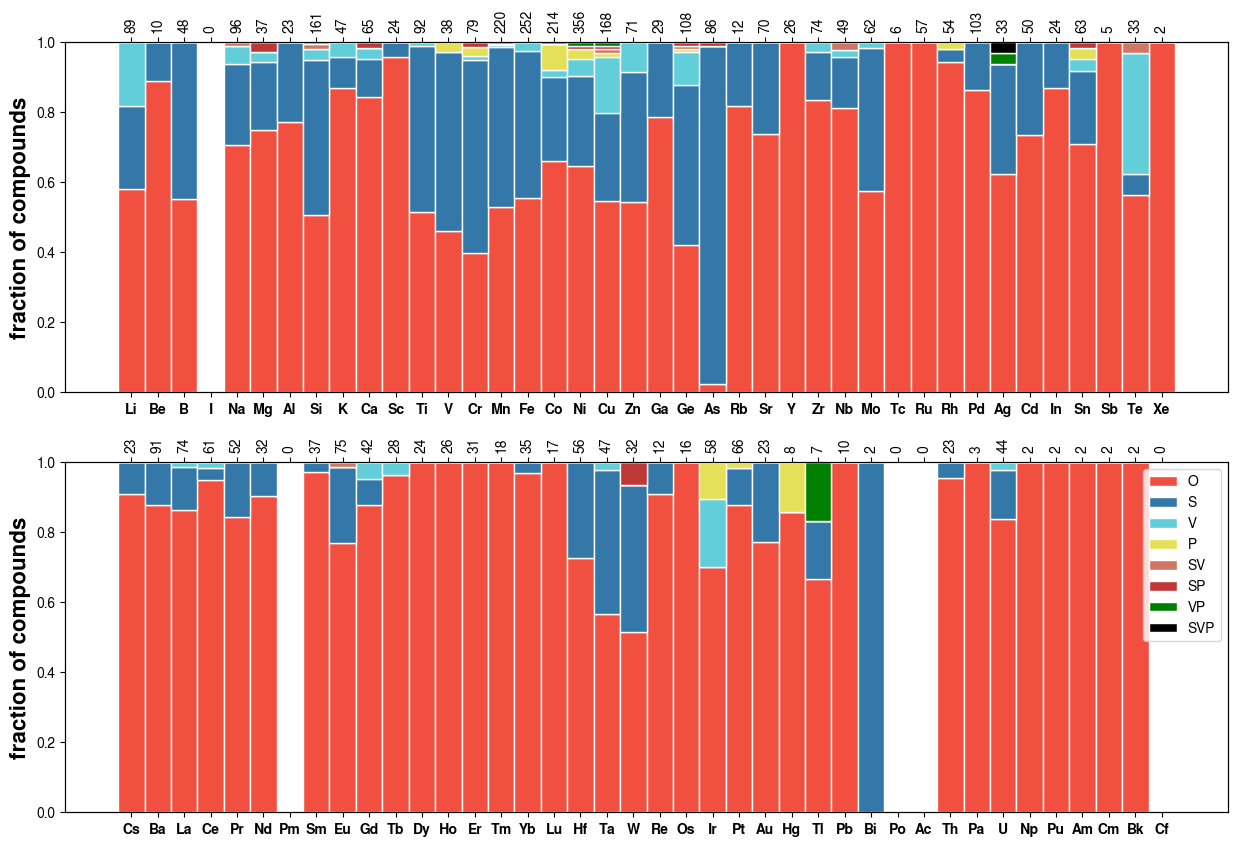

In [105]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='P'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='C'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/phosphides.png',n=40,frac=True,barWidth=1)

# Chlorides

In [106]:
len(oxides)

1888

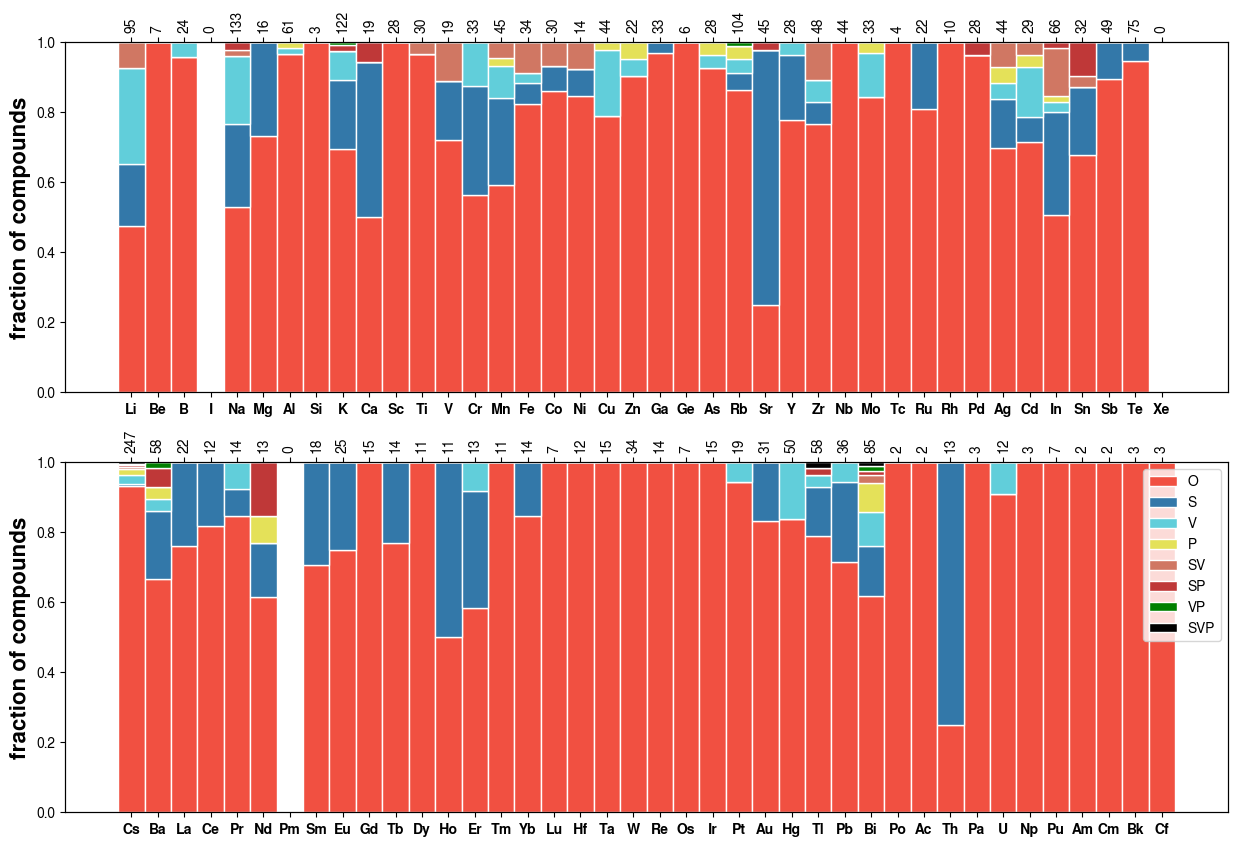

In [107]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='Cl'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='C'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/chlorides.png',n=40,frac=True,barWidth=1)

# Selenides

In [116]:
len(oxides)

1121

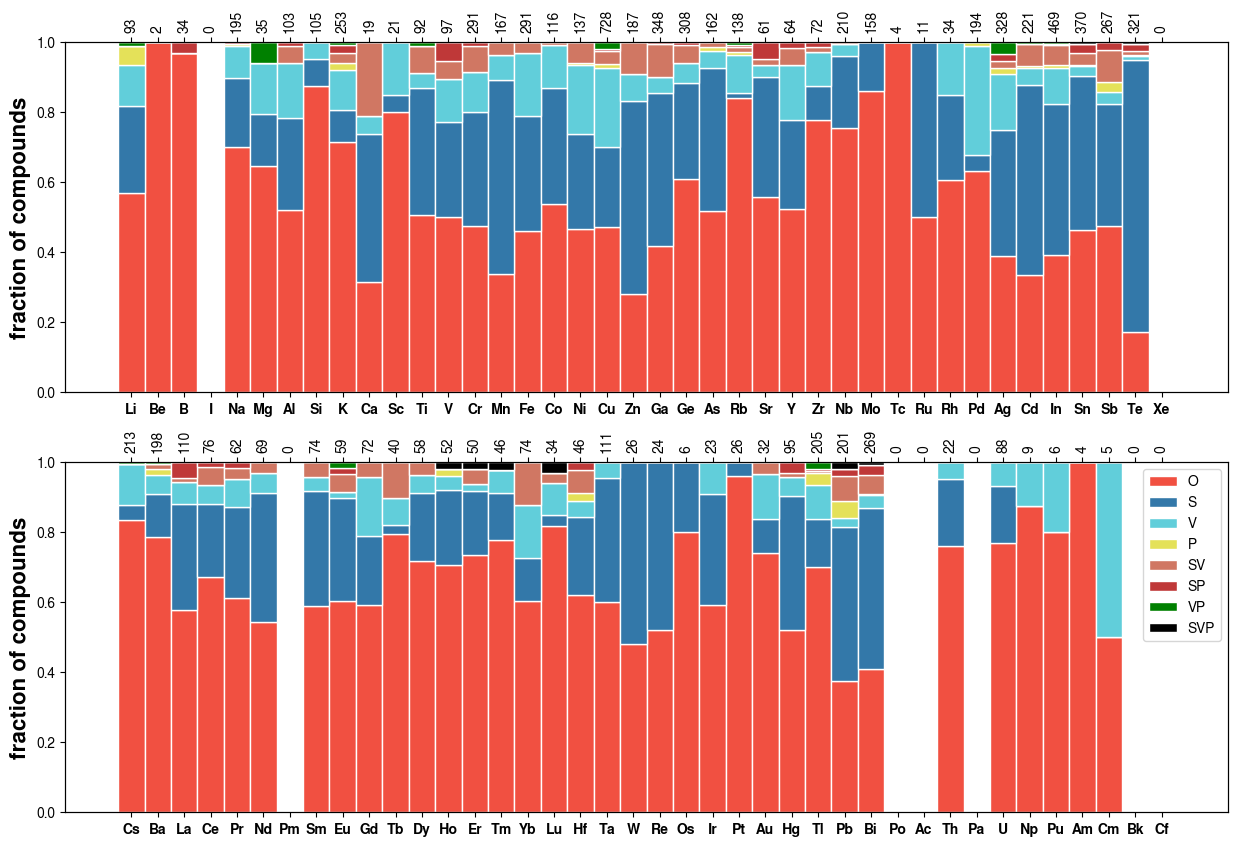

In [118]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='Se'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='C' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='Br'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/selenides.png',n=40,frac=True,barWidth=1)

# Bromides

In [120]:
len(oxides)

3793

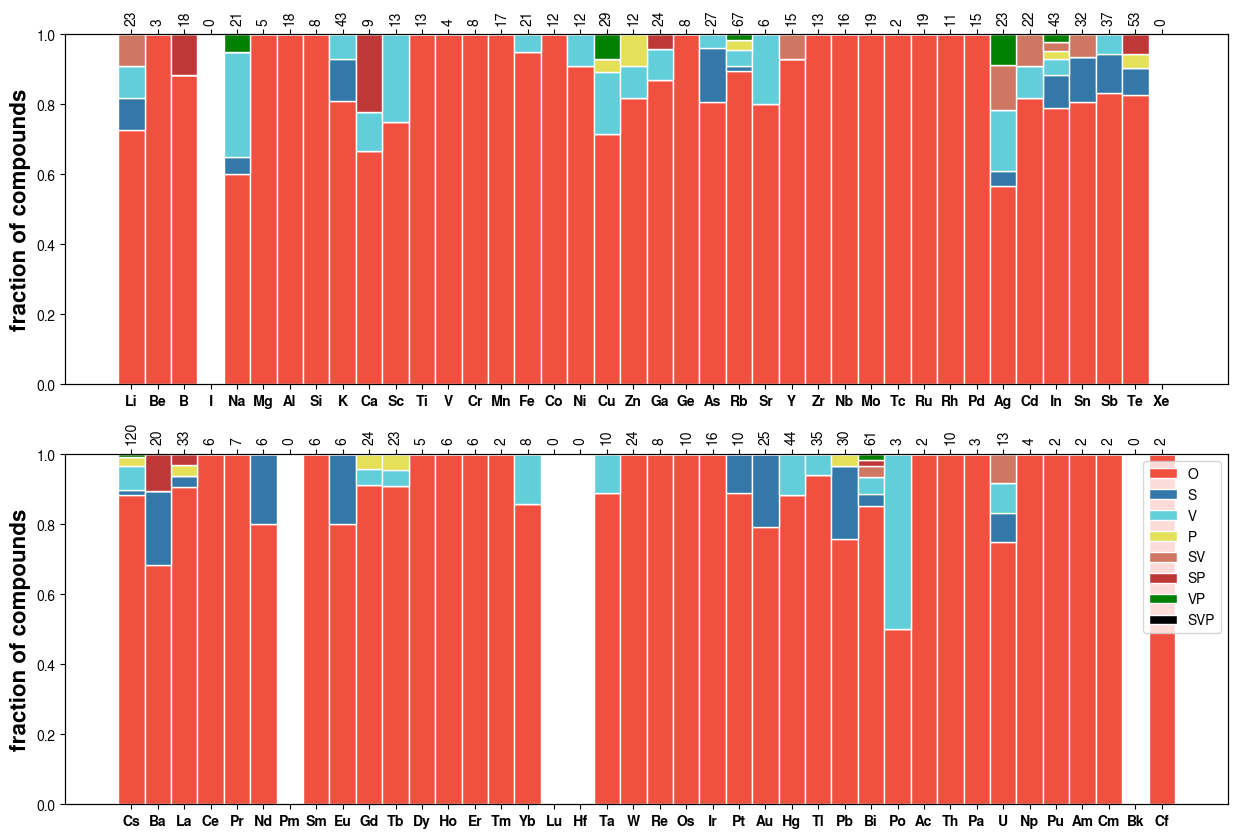

In [121]:
ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    switchH=0
    switchC=0
    for orb in elem_orb:
        for el in orb:
            if(el=='Br'):
                switch=1
            elif(el=='H'):
                switchH=1
            elif(el=='Se' or el=='S'or el=='N'or el=='I'or el=='Cl'or el=='O'or el=='P'or el=='C'or el=='I'):
                switchC=1
    if(switch==1 and switchC==0 and switchH==0):
        ind.append(i)

oxides=dbmax_struct.iloc[ind]
oxides.reset_index(inplace=True, drop=True)
len(oxides)

elem_oxides=['Li', 'Be', 'B', 'I', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
           'Ga', 'Ge', 'As', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
           'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 
           'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 
           'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ac', 'Th',
           'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

elem_disorder, elem_disorder_frac=calculate_elements(elem_oxides,oxides)

plot_elements(elem_disorder_frac, filename='images/bromides.png',n=40,frac=True,barWidth=1)

# Intermetallics

In [122]:
len(oxides)

644

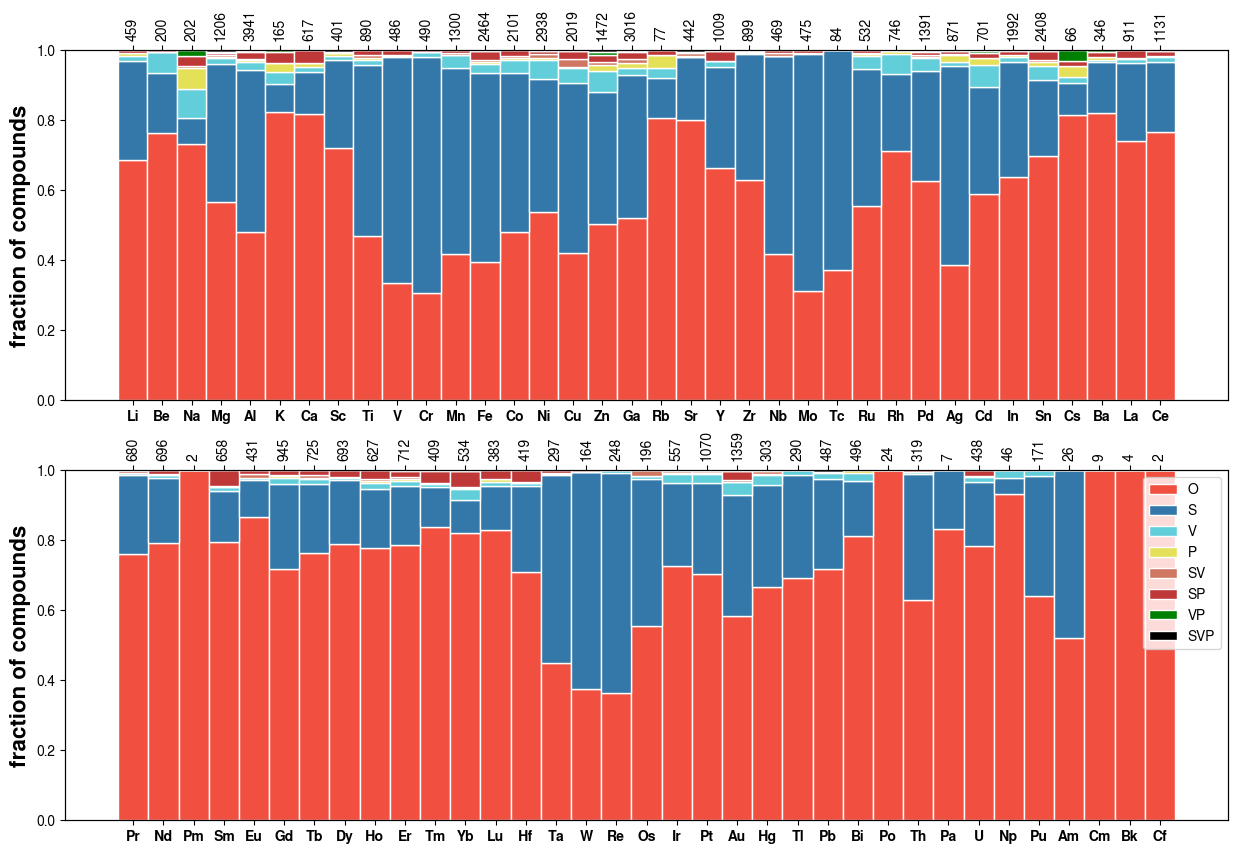

In [125]:
metal_el=['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni',
          'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 
          'In', 'Sn', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
          'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 
          'Bi', 'Po', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

len(metal_el)

ind=[]
for i,elem_orb in enumerate(dbmax_struct['orbit_elements_comp'].values):
    switch=0
    for orb in elem_orb:
        for el in orb:
            if(el not in metal_el):
                switch=1
    if(switch==0):
        ind.append(i)

intermetallics=dbmax_struct.iloc[ind]
len(intermetallics)

elem_disorder, elem_disorder_frac=calculate_elements(metal_el,intermetallics)

plot_elements(elem_disorder_frac, filename='images/intermetallics.png',n=36,frac=True,barWidth=1)

# group_disorder, group_disorder_frac=calculate_for_point_groups(oxides,inv_map)

# plot_groups(group_disorder_frac, filename='oxides-s.png', frac=True,barWidth=1,names=list(mapping_groups.keys()))

# Substitutional disorder

In [129]:
len(intermetallics)

17766

In [223]:
# Modified Pettifor
mendeleev={'He':1, "Ne":2, 'Ar':3, 'Kr':4, 'Xe':5, 'Rn': 6, 'Fr':7,'Cs':8, 'Rb':9,'K':10,
          'Na':11,'Li':12,'Ra':13,'Ba':14,'Sr':15,'Ca':16,'Eu':17,'Yb':18,'Lu':19,'Tm':20,
          'Y':21,'Er':22, 'Ho':23, 'Dy':24, 'Tb':25,'Gd':26,'Sm':27,'Pm':28,'Nd':29,'Pr':30,
          'Ce':31,'La':32,'Ac':33, 'Th':34, 'Pa':35, 'U':36, 'Np':37, 'Pu':38, 'Am':39, 'Cm':40,
          'Bk':41,'Cf':42,'Es':43, 'Fm':44, 'Sc':45,'Zr':46,'Hf':47,'Ti':48,'Ta':49,'Nb':50,
          'V':51,'Cr':52,'Mo':53,'W':54,'Re':55,'Tc':56,'Os':57, 'Ru':58,'Ir':59,'Rh':60,
          'Pt':61,'Pd':62, 'Au':63, 'Ag':64, 'Cu':65,'Ni':66,'Co':67,'Fe':68,'Mn':69,'Mg':70,
          'Zn':71,'Cd':72,'Hg':73,'Be':74, 'Al':75,'Ga':76,'In':77,'Tl':78,'Pb':79,'Sn':80,
          'Ge':81,'Si':82,'B':83, 'C':84,'N':85,'P':86,'As':87,'Sb':88,'Bi':89,'Po':90,
          'Te':91,'Se':92,'S':93,'O':94,'At':95,'I':96,'Br':97,'Cl':98,'F':99,'H':100}

men=pd.DataFrame.from_dict(mendeleev,orient='index').sort_values(by=0)

In [226]:
do=dbmax_struct.loc[dbmax_struct['disorder_set']=={'O'}]
ds=dbmax_struct.loc[dbmax_struct['disorder_set'].isin([{'S'}, {'O','S'}])]

do2=do.loc[do['num_el']==2]
ds2=ds.loc[ds['num_el']==2]

do2.reset_index(drop=True,inplace=True)
ds2.reset_index(drop=True,inplace=True)

In [227]:
from pymatgen.core.composition import Composition

MA=[]
MB=[]
exceptions=[]

for i in range(len(do2)):
    try:
        comp=Composition(do2['formula'][i])
        if(str(comp.elements[0]) in mendeleev.keys() 
           and str(comp.elements[1]) in mendeleev.keys()):
            x1=comp.get_atomic_fraction(comp.elements[0])
            x2=comp.get_atomic_fraction(comp.elements[1])
            if(x1>x2):
                MA.append(mendeleev[str(comp.elements[0])])
                MB.append(mendeleev[str(comp.elements[1])])
            else:
                MA.append(mendeleev[str(comp.elements[1])])
                MB.append(mendeleev[str(comp.elements[0])])
        else:
            exceptions.append(i)
    except:
        exceptions.append(i)

print(len(do2),len(MA),len(MB),len(exceptions))

do2.drop(index=exceptions,inplace=True)
do2['MA']=MA
do2['MB']=MB

from pymatgen.core.composition import Composition

MA=[]
MB=[]
exceptions=[]

for i in range(len(ds2)):
    try:
        comp=Composition(ds2['formula'][i])
        if(str(comp.elements[0]) in mendeleev.keys() 
           and str(comp.elements[1]) in mendeleev.keys()):
            x1=comp.get_atomic_fraction(comp.elements[0])
            x2=comp.get_atomic_fraction(comp.elements[1])
            if(x1>x2):
                MA.append(mendeleev[str(comp.elements[0])])
                MB.append(mendeleev[str(comp.elements[1])])
            else:
                MA.append(mendeleev[str(comp.elements[1])])
                MB.append(mendeleev[str(comp.elements[0])])
        else:
            exceptions.append(i)
    except:
        exceptions.append(i)
ds2.drop(index=exceptions,inplace=True)
ds2['MA']=MA
ds2['MB']=MB
print(len(ds2),len(MA),len(MB),len(exceptions))

8120 8120 8120 0
2186 2186 2186 0


In [228]:
colorscale=create_colorscale((27, 54, 87),(242, 80, 65),50)

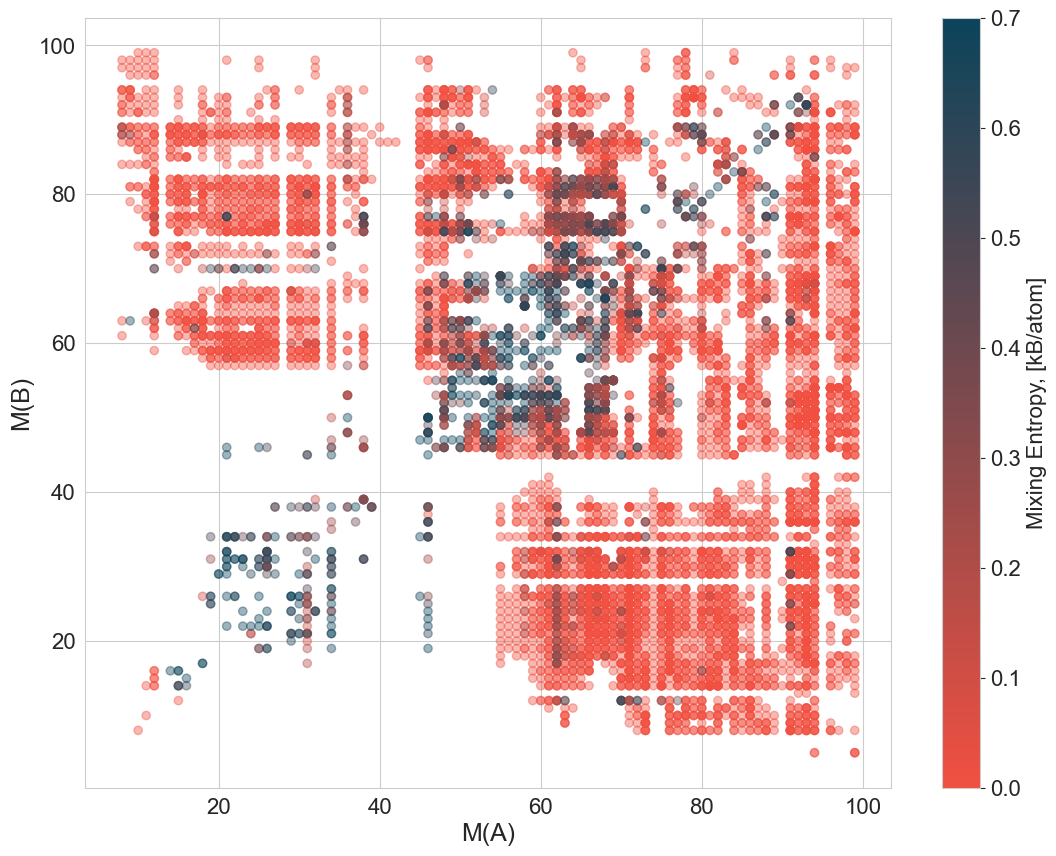

In [236]:
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top=np.ones((256, 4))
bottom=np.ones((128, 4))

top[:,0]=np.linspace(242/256,11/256,256)
top[:,1]=np.linspace(80/256,68/256,256)
top[:,2]=np.linspace(65/256,91/256,256)
# top[:,0]=np.linspace(242/256,97/256,128)
# top[:,1]=np.linspace(80/256,207/256,128)
# top[:,2]=np.linspace(65/256,219/256,128)
# bottom[:,0]=np.linspace(97/256,11/256,1,128)
# bottom[:,1]=np.linspace(207/256,68/256,1,128)
# bottom[:,2]=np.linspace(219/256,91/256,1,128)


# newcolors = np.vstack((top,bottom))
newcolors=top
newcmp = ListedColormap(newcolors, name='OrangeBlue')

cmap =  ListedColormap(newcolors)
norm = mpl.colors.Normalize(vmin=0, vmax=0.7)
plt.figure(figsize=(13,10))
plt.scatter(do2['MA'],do2['MB'],alpha=0.4,c=do2['mixing_entropy'],cmap=cmap)
plt.scatter(ds2['MA'],ds2['MB'],alpha=0.4,c=ds2['mixing_entropy'],cmap=cmap)
# plt.scatter(dv2['MA'],dv2['MB'],alpha=0.4,c=dv2['mixing_entropy'])
# plt.scatter(dp2['MA'],dp2['MB'],alpha=0.4,c=dp2['mixing_entropy'])
# plt.xticks(np.linspace(1,100,100),men.index,fontsize=5)
# plt.yticks(np.linspace(1,100,100),men.index,fontsize=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('M(A)',fontsize=18)
plt.ylabel('M(B)',fontsize=18)

cmap =  ListedColormap(newcolors)
norm = mpl.colors.Normalize(vmin=0, vmax=0.7)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm,cmap=cmap),
    ax=plt.gca()
)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label='Mixing Entropy, [kB/atom]', size=16)
# plt.savefig('images/mixing-entropy-binary.png', transparent=None, dpi=400, format='png',pad_inches='tight')
# plt.xticks()
plt.show()

In [168]:
# Modified Pettifor scale from Glawe et al.2016

mendeleev={'He':1, "Ne":2, 'Ar':3, 'Kr':4, 'Xe':5, 'Rn': 6, 'Fr':7,'Cs':8, 'Rb':9,'K':10,
          'Na':11,'Li':12,'Ra':13,'Ba':14,'Sr':15,'Ca':16,'Eu':17,'Yb':18,'Lu':19,'Tm':20,
          'Y':21,'Er':22, 'Ho':23, 'Dy':24, 'Tb':25,'Gd':26,'Sm':27,'Pm':28,'Nd':29,'Pr':30,
          'Ce':31,'La':32,'Ac':33, 'Th':34, 'Pa':35, 'U':36, 'Np':37, 'Pu':38, 'Am':39, 'Cm':40,
          'Bk':41,'Cf':42,'Es':43, 'Fm':44, 'Sc':45,'Zr':46,'Hf':47,'Ti':48,'Ta':49,'Nb':50,
          'V':51,'Cr':52,'Mo':53,'W':54,'Re':55,'Tc':56,'Os':57, 'Ru':58,'Ir':59,'Rh':60,
          'Pt':61,'Pd':62, 'Au':63, 'Ag':64, 'Cu':65,'Ni':66,'Co':67,'Fe':68,'Mn':69,'Mg':70,
          'Zn':71,'Cd':72,'Hg':73,'Be':74, 'Al':75,'Ga':76,'In':77,'Tl':78,'Pb':79,'Sn':80,
          'Ge':81,'Si':82,'B':83, 'C':84,'N':85,'P':86,'As':87,'Sb':88,'Bi':89,'Po':90,
          'Te':91,'Se':92,'S':93,'O':94,'At':95,'I':96,'Br':97,'Cl':98,'F':99,'H':100}

In [169]:
elem_list=list(mendeleev.keys())

In [170]:
orbit_elements=[]
for i in range(len(dbmax_struct)):
    dx=dbmax_struct.iloc[i]
    elem={}
    for j,values in dx['species'].items():
        el=[]
        for sp in values.keys():
            el.append(str(Species(sp).element))
        elem[j]=el
    orbit_elements.append(elem)
dbmax_struct['orbit_elements']=orbit_elements

/tmp/ipykernel_9559/3988858379.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [171]:
pairs={}
entropies={}
ids={}
for el in elem_list:
    pairs[el]=[]
    entropies[el]=[]
    ids[el]=[]

In [172]:
for i in range(len(dbmax_struct)):
    order=dbmax_struct['orbit_disorder'].values[i].values()
    elem=dbmax_struct['orbit_elements'].values[i]

    for j,orb in enumerate(list(order)):
        if(orb in ['S','SP','SV','SPV']):
#         if(orb in ['S']):
            for el in elem[str(j)]:
                for el1 in elem[str(j)]:
                    if(el1!=el):
#                         if(el=='Al' and el1=='Si'):
#                             ids[el].append(i)
                        pairs[el].append(el1)
                        entropies[el].append(dbmax_struct['mixing_entropy'].values[i])

In [173]:
totals={}
for el in elem_list:
    totals[el]=0
    for n in range(len(dbmax_struct)):
        orb_el=dbmax_struct['orbit_elements'].values[n].values()
        switch=0
        for el_l in orb_el:
            if(el in el_l):
                switch=1
        if(switch==1):
            totals[el]+=1

In [174]:
# we normalise by the total number of subtitutional orbits with this element. Maybe need to normalize by the 
# frequencey of another element
pairs1={}
for key,val in pairs.items():
    pairs1[key]={}
    for el in elem_list:
#         if(val.count(el)>0):
        if(totals[el]>0 and totals[key]>0):
            pairs1[key][el]=val.count(el)/totals[el]/totals[key]
        else:
            pairs1[key][el]=0
    s=np.sum(list(pairs1[key].values()))
    if(s>0):
        for el in elem_list:
            pairs1[key][el]=pairs1[key][el]/s

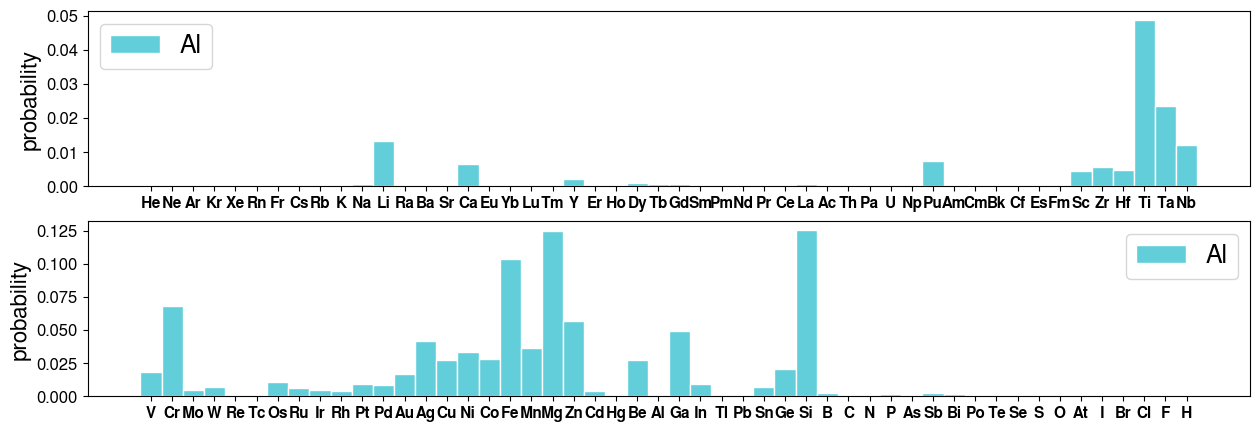

In [176]:
element='Al'

bars1=[]
names=[]
r=[]
for i,key in enumerate(pairs1[element].keys()):
    names.append(key)
    bars1.append(pairs1[element][key])
    r.append(i)
barWidth = 1

plt.figure(figsize=(15,5))
# Create brown bars
plt.subplot(211)

plt.bar(r[:50], bars1[:50], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label=element)
# (38/256, 157/256, 172/256)(51/256, 133/256, 167/256)
# Custom X axis
plt.xticks(r[:50], names[:50], fontweight='bold',fontsize=11)
plt.yticks(fontsize=12)
plt.ylabel('probability',fontsize=16)
plt.legend(fontsize=18)

plt.subplot(212)
plt.bar(r[50:], bars1[50:], color=(97/256, 207/256, 219/256), edgecolor='white', width=barWidth,label=element)

 
# Custom X axis
plt.xticks(r[50:], names[50:], fontweight='bold',fontsize=11)
plt.yticks(fontsize=12)
plt.ylabel('probability',fontsize=16)
plt.grid(visible=False)

plt.legend(fontsize=18)
plt.savefig('images/Al-substitution.png', transparent=None, dpi=400, format='png',pad_inches='tight')

plt.show()

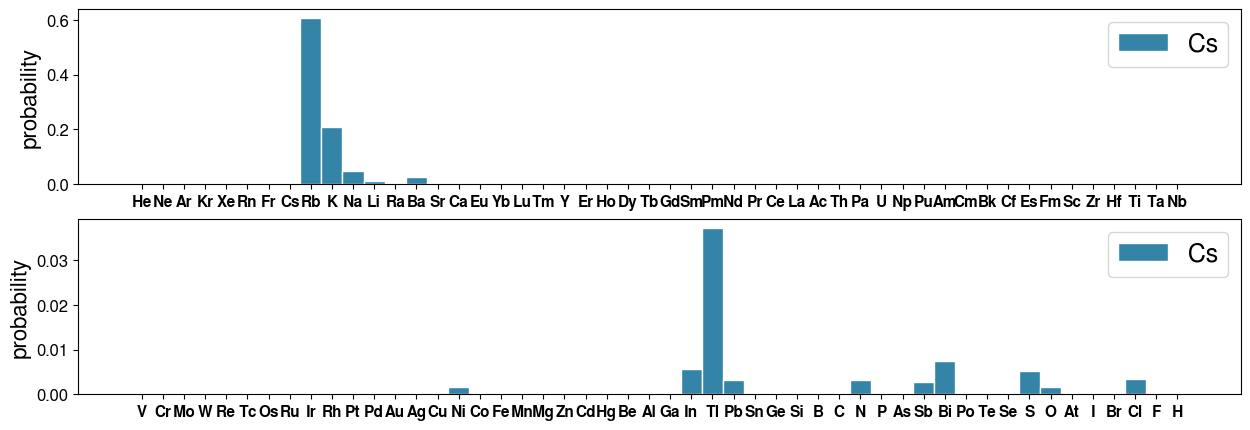

In [179]:
element='Cs'

bars1=[]
names=[]
r=[]
for i,key in enumerate(pairs1[element].keys()):
    names.append(key)
    bars1.append(pairs1[element][key])
    r.append(i)
barWidth = 1

plt.figure(figsize=(15,5))
# Create brown bars
plt.subplot(211)

plt.bar(r[:50], bars1[:50], color=(51/256, 133/256, 167/256), edgecolor='white', width=barWidth,label=element)
# (38/256, 157/256, 172/256)(51/256, 133/256, 167/256)
# Custom X axis
plt.xticks(r[:50], names[:50], fontweight='bold',fontsize=11)
plt.yticks(fontsize=12)
plt.ylabel('probability',fontsize=16)
plt.legend(fontsize=18)

plt.subplot(212)
plt.bar(r[50:], bars1[50:], color=(51/256, 133/256, 167/256), edgecolor='white', width=barWidth,label=element)

 
# Custom X axis
plt.xticks(r[50:], names[50:], fontweight='bold',fontsize=11)
plt.yticks(fontsize=12)
plt.ylabel('probability',fontsize=16)
plt.grid(visible=False)

plt.legend(fontsize=18)
plt.savefig('images/Cs-substitution.png', transparent=None, dpi=400, format='png',pad_inches='tight')

plt.show()